In [1]:
import numpy as py
import pandas as pd
import warnings
import requests
import re
import statistics
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np
from statistics import mode
from bs4 import BeautifulSoup
from wordcloud import WordCloud
from matplotlib.cm import ScalarMappable
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score, precision_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

warnings.filterwarnings('ignore')


In [ ]:
##Creating characters_df dataframe from movie_characters_metadata.tsv

column_names = ['character_id', 'character_name', 'movie_id', 'movie_name', 'character_gender', 'position_credits']
characters_df = pd.read_csv('dataset/movie_characters_metadata.tsv', sep='\t', header=None, names=column_names, on_bad_lines='skip')
print("SUCESS : 'characters_df' dataframe created from 'movie_characters_metadata.tsv'\n")
print('Here is a snapshot of data')
characters_df.head()

In [ ]:
##Creating the dataframe : titles_df

column_names = ['movie_id', 'movie_name', 'movie_year', 'movie_rating', 'movie_votes', 'movie_genre']
titles_df = pd.read_csv('dataset/movie_titles_metadata.tsv', sep='\t', names=column_names, header=None, on_bad_lines='skip')
print("SUCESS : 'titles_df' dataframe created from 'movie_titles_metadata.tsv'\n")
print('Here is a snapshot of data')
titles_df.head()

In [ ]:
column_names = ['line_id', 'character_id', 'movie_id', 'character_name', 'character_line']
lines_df = pd.read_csv('dataset/movie_lines.tsv', sep='\t', header=None,names=column_names, on_bad_lines='skip')
print("SUCESS : 'lines_df' dataframe created from 'movie_lines.tsv'\n")
print('Here is a snapshot of data')
lines_df.head()

In [ ]:
column_names = ['character_id1', 'character_id2','movie_id', 'line_list']
conversations_df = pd.read_csv('dataset/movie_conversations.tsv', sep='\t',names=column_names, header=None, on_bad_lines='skip')
print("SUCESS : 'conversations_df' dataframe created from 'movie_conversations.tsv'\n")
print('Here is a snapshot of data')
conversations_df.head()

In [ ]:
column_names = ['movie_id','movie_name','url']
raw_script_df = pd.read_csv('dataset/raw_script_urls.tsv', sep='\t', names=column_names, header=None, on_bad_lines='skip')
raw_script_df.head()

In [ ]:
imdb_movie_title_df = pd.read_csv('dataset/title.basics.tsv.gz', sep='\t', on_bad_lines='skip', compression='gzip')
imdb_movie_title_df.head()

In [ ]:
imdb_movie_title_df.titleType.value_counts()

In [ ]:
imdb_movie_title_df = imdb_movie_title_df[imdb_movie_title_df.titleType == 'movie']

In [ ]:
imdb_movie_crew_df = pd.read_csv('dataset/title.crew.tsv.gz', sep='\t', on_bad_lines='skip', compression='gzip')
imdb_movie_crew_df.head()

In [ ]:
imdb_crew_name_df = pd.read_csv('dataset/name.basics.tsv.gz', sep='\t', on_bad_lines='skip', compression='gzip')
imdb_crew_name_df.head()

In [ ]:
(titles_df['movie_name'].str.upper()).isin(imdb_movie_title_df['primaryTitle'].str.upper()).value_counts()

In [ ]:
imdb_df = imdb_movie_title_df.merge(imdb_movie_crew_df, on='tconst', how='left').merge(imdb_crew_name_df, left_on='directors', right_on='nconst', how='left')

imdb_df.head()

In [ ]:
titles_df['movie_name_upper'] = titles_df['movie_name'].str.upper()
imdb_df['primaryTitle_upper'] = imdb_df['primaryTitle'].str.upper()


In [ ]:
imdb_df.loc[imdb_df['primaryTitle_upper'] == '10 THINGS I HATE ABOUT YOU']

In [ ]:
titles_df.head()

In [ ]:
imdb_df.head()

In [ ]:
titles_df['movie_name_upper'].isin(imdb_df['primaryTitle_upper']).value_counts()

In [ ]:
movie_titles_directors_df = titles_df.merge(imdb_df, left_on=['movie_name_upper', 'movie_year'], right_on=['primaryTitle_upper', 'startYear'], how='left')[['movie_id', 'movie_name', 'movie_year', 'movie_rating', 'movie_genre', 'primaryName']]
movie_titles_directors_df.columns = ['movie_id', 'movie_name', 'movie_year', 'movie_rating', 'movie_genre', 'director_name']
movie_titles_directors_df.head(20)

In [ ]:
movie_titles_directors_df.duplicated().value_counts()

In [ ]:
movie_titles_directors_df['director_gender'] = 'Unknown'
movie_titles_directors_df.head()

In [ ]:
movie_titles_directors_df['director_name'].fillna('Unknown', inplace=True)

In [ ]:
def identify_gender(text):
    male_pronouns = ['he', 'him', 'his']
    female_pronouns = ['she', 'her', 'hers']

    words = text.lower().split()

    male_count = len([w for w in words if w in male_pronouns])
    female_count = len([w for w in words if w in female_pronouns])

    if male_count > female_count:
        return 'M'
    elif female_count > male_count:
        return 'F'
    else:
        return 'Unknown'

for index, row in movie_titles_directors_df.iterrows():
	dg=[]
	paragraphs = []
	url = "https://en.wikipedia.org/wiki/" + row['director_name'].replace(" ", "_")
	response = requests.get(url)
	soup = BeautifulSoup(response.content, "html.parser")

	if len(soup.findAll("p")) == 1:
		paragraphs.clear()
		url = "https://en.wikipedia.org/wiki/" + row['director_name'].replace(" ", "_") + "_(director)"
		response = requests.get(url)
		soup = BeautifulSoup(response.content, "html.parser")

	paragraphs = (soup.findAll("p"))

	# print(paragraphs)
	for (i, p) in enumerate(paragraphs):
		if row['director_name'] == "Stephen Hopkins":
			print(identify_gender(p.text))
		dg.append(identify_gender(p.text))

	if 'Unknown' in dg:
		dg = [i for i in dg if i != 'Unknown']

	if len(dg) == 0:
		dg.append('Unknown')

	# print(row['director_name'])
	# print(mode(dg))
	movie_titles_directors_df.loc[index, 'director_gender'] = mode(dg)
	dg.clear()

In [ ]:
movie_titles_directors_df.head(20)

In [ ]:
movie_titles_directors_df.director_gender.value_counts()

In [ ]:
final_df = movie_titles_directors_df.merge(characters_df, on='movie_id', how='left').merge(lines_df, on=['movie_id', 'character_id'], how='left')
final_df.drop(['movie_name_y', 'character_name_y'], axis=1, inplace=True)
final_df.columns=['movie_id', 'movie_name', 'movie_year',	'movie_rating',	'movie_genre','director_name'	,'director_gender'	,'character_id',	'character_name',	'character_gender',	'position_credits',	'line_id',	'character_line']
final_df.head(20)

In [ ]:
final_df.info()

In [ ]:
print("Distribution Of NaN across dataframe")
nan_percentage = (final_df.isna().mean() * 100).round(5)
print(nan_percentage)

In [ ]:
num_rows_dropped = final_df.isna().any(axis=1).sum()
print("Number of rows that would be dropped due to NaN:", num_rows_dropped)

In [ ]:
# Removing rows with NaN values
final_df = final_df.dropna()

In [ ]:
# Remove duplicate rows
duplicate_counts = final_df.duplicated().sum()
print("Total duplicate", duplicate_counts)
if duplicate_counts > 0:
  characters_df = final_df.drop_duplicates()

In [ ]:
column_name = 'movie_year'

# Filter non-numeric values in the specified column
non_numeric_values = final_df.loc[~pd.to_numeric(final_df[column_name], errors='coerce').notna(), column_name]

# Get unique non-numeric values
unique_non_numeric_values = non_numeric_values.unique()

# Display the unique non-numeric values
print("Unique non-numeric values in column '{}':".format(column_name))
print(unique_non_numeric_values)

In [ ]:
column_name = 'movie_year'

# Extract numeric portion using regular expression
final_df[column_name] = final_df[column_name].str.extract('(\d+)', expand=False)
final_df[column_name] = final_df[column_name].astype(int)

In [ ]:
final_df.movie_year.unique()

In [ ]:
##Count of values of each gender type
final_df.character_gender.value_counts()

In [ ]:
##Data Analysis to check if any chId has multiple gender assigned to it.
##Result: None found
grouped = final_df.groupby('character_id')['character_gender'].nunique()
characters_with_multiple_genders = grouped[grouped > 1].index.tolist()
print("characters with more than one gender:", len(characters_with_multiple_genders))

In [ ]:
##Removing data ambiguity from gender
final_df = final_df[final_df.character_gender != '?']
final_df.character_gender = final_df.character_gender.apply(lambda g: 'M' if g in ['m', 'M'] else 'F')
print("Data Distribution Per Gender:")
final_df.groupby('character_gender')['character_id'].nunique()

In [ ]:
final_df.info()

In [ ]:
non_numeric_position_credits = final_df.loc[~pd.to_numeric(final_df['position_credits'], errors='coerce').notna(), 'position_credits'].unique()
print("Non-numeric values in 'position_credits' column:", non_numeric_position_credits)


#Examine the distribution of male & female with this junk data
filtered_df = final_df[final_df['position_credits'] == '?']
# Count the number of males and females
male_count = filtered_df[filtered_df['character_gender'] == 'M']
female_count = filtered_df[filtered_df['character_gender'] == 'F']

print("Number of males with position_credits = '?':", male_count.groupby('character_gender')['character_id'].nunique())
print("Number of females with position_credits = '?':", female_count.groupby('character_gender')['character_id'].nunique())

In [ ]:
final_df['position_credits'] = final_df['position_credits'].replace('?', -1).astype(int)
final_df.describe()

In [ ]:
##Get the number of unique dialogues spoken by each characters.
final_df['character_dialog_count'] = final_df.groupby(['character_id', 'movie_id'])['character_line'].transform('count')

##Get the number of words per dialogue
final_df['dialog_word_count'] = final_df.character_line.str.count(' ') + 1

##Get number of character in the dialog
final_df['dialog_length'] = final_df.character_line.str.len()

In [ ]:
final_df.head()

In [ ]:
final_df.to_csv('final_df.csv', sep=',', index=False, encoding='utf-8')

In [4]:
final_df = pd.read_csv('final_df.csv')

In [5]:
df = pd.read_csv('final_df.csv')

In [6]:
df=final_df.copy()

###Creating Wordcloud out of Movie Names

In [7]:
movie_names_df = df.drop_duplicates(subset = "movie_id")
movie_names_df.movie_name

0         10 things i hate about you
623       1492: conquest of paradise
765                       15 minutes
1283           2001: a space odyssey
1428                         48 hrs.
                     ...            
227214              the wizard of oz
227701       the world is not enough
227981                      watchmen
228285                           xxx
228621            young frankenstein
Name: movie_name, Length: 588, dtype: object

In [ ]:
#Concatenate all dialogue lines
all_lines = ' '.join(movie_names_df['movie_name'])

#Create a word cloud with larger figure size
plt.figure(figsize=(15, 10))
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(all_lines)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Titles')
plt.show()

The most frequent words in the movie titles are **“star”, “trek”, “black”, “men”, “day”, “night”, “american”, “dead”, “thing”, “house”, “nightmare”, “elm”, “street”, “batman”, “jurassic”, “park”, “wild”, “lost”, “world”, “brown”, “jaws”, “mission”, “impossible”, “voyage”, “earth”, “game”, “happy”, “hotel”, “meet”, “hard”, “scream”, “basic”, “rush”, “13th”, “part”, “final”, “blue”, “hellraiser”, “dark”, “friday”, “thing”, “scream” **.

<br>



Based on this word cloud, we can conclude that the most common themes in the movie titles are related to **science fiction, horror, action, and adventure genres**. The words “star”, “trek”, “black”, “men”, “day”, “night”, “american”, “dead”, “thing”, “house”, “nightmare”, “elm”, “street”, “batman”, “jurassic”, “park”, “wild”, “lost”, “world”, “brown”, “jaws”, “mission”, “impossible”, “voyage”, “earth”, “game”, “happy”, “hotel”, “meet”, “hard”, “scream”, “basic”, “rush”, “13th”, “part”, “final”, “blue”, “hellraiser”, “dark”, “friday”, “thing”, and “scream” are indicative of the most popular movie franchises and titles in these genres.

### Creating Wordcloud out of Character Names

In [ ]:
character_names_df = df.drop_duplicates(subset = "character_id")
character_names_df.character_name

In [ ]:
#Concatenate all dialogue lines
all_lines = ' '.join(character_names_df['character_name'])

#Create a word cloud with larger figure size
plt.figure(figsize=(15, 10))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_lines)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud based on Character Names')
plt.show()

Based on the word cloud, we can conclude that the most common character names in the 588 movies are ***Jack, John, Michael, George, and Nick***. We can also see that there are other names that are less common, but still appear in the word cloud such as ***Paul, Sam, Betty, Kirk, and Tom***.

### Gender Distribution of movie Characters across movies in given data

In [ ]:
Gender_distribution = df.drop_duplicates(subset = "character_id")
Gender_distribution

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the occurrences of each unique value in 'character_gender'
gender_counts = Gender_distribution['character_gender'].value_counts()

# Create a horizontal bar plot using seaborn with custom colors
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))  # Adjust the figure size as needed
ax = sns.barplot(x=gender_counts.values, y=gender_counts.index, palette=['#cedcab', '#e27557'], edgecolor='black')

# Set labels and title
plt.xlabel('Count')
plt.ylabel('Gender')
plt.title('Distribution of Character Gender')

# Remove grid lines
ax.grid(False)

# Add count labels on the bars
for i, v in enumerate(gender_counts.values):
    ax.text(v + 0.1, i, str(v), color='black', ha='left', va='center')

# Show the plot
plt.show()

We have total of **2951 Characters** across 588 Movies.

Out of these ***2003 Characters are of Male Gender and 948 Female***

### Now, Let's see how the data for movies is distributed over the years italicized text

In [ ]:
movie_year_df = df.drop_duplicates(subset = "movie_id")
movie_year_df

In [ ]:
# Count the occurrences of each year based on unique mId values
year_counts_unique = movie_year_df.groupby('movie_year')['movie_id'].nunique()

# Create a color gradient
colors = plt.cm.viridis(np.linspace(0, 1, len(year_counts_unique)))

# Create a bar plot for year distribution based on unique mId
plt.figure(figsize=(18, 8))  # Adjust the figure size as needed
bars = plt.bar(year_counts_unique.index.astype(str), year_counts_unique, color=colors)
plt.xlabel('Year')
plt.ylabel('Count (Unique mId)')
plt.title('Distribution of Unique Movies Over the Years')

# Remove grids
plt.grid(False)

# Create a ScalarMappable to create a colorbar
sm = ScalarMappable(cmap=plt.cm.viridis)
sm.set_array([])  # An array must be set, but it can be empty

# # Add a color bar for the gradient
# color_bar = plt.colorbar(sm, orientation='vertical', pad=0.05)
# color_bar.set_label('Color Gradient')

# Adjust x-axis limits for a little space on both sides
plt.margins(x=0.05)

plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

The data ranges from the year 1926 all the way upto 2010. While we have wide-ranging data, the majority of it lies in the 3 decades of the 1980s, 1990s and 2000s, with 490 of the 617 i.e., ∼79% of the movies in that period. This sample space has enough of a time-spread for us to analyze how representation of women and the general attitude towards them in movies has changed over time.

### Analysing Movies for Ratings Received

In [ ]:
movie_rating_df = df.drop_duplicates(subset = "movie_id")
movie_rating_df

In [ ]:
movie_rating_df.movie_rating.describe()

We observe that the highest Rated movie had 9.3 Rating

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#Assuming your analysis DataFrame is named analysis_df
#Extract the 'movie_rating' column for plotting
movie_ratings = movie_rating_df['movie_rating']

#Create a histogram for movie ratings
plt.figure(figsize=(10, 6))
sns.histplot(movie_ratings, bins=20, kde=True, color='#6aaa96')
plt.xlabel('Movie Rating')
plt.ylabel('Count')
plt.title('Distribution of Movie Ratings')

# Remove grids
plt.grid(False)

#Show the plot
plt.show()

Based on the graph, we can conclude that the majority of the movies have a rating between 6 and 8. The highest number of ratings is around 7.5. This suggests that most movies are rated between 6 and 8, with a few outliers on either end.

**9.5 is the highest rating received by any movie in our current dataset.**

### Let's Explore dialogue count per Gender

In [ ]:
gender_dialogue_df = df.drop_duplicates(subset = "character_id")
gender_dialogue_df

In [ ]:
dialogue_per_gender = gender_dialogue_df.groupby('character_gender')['character_dialog_count'].sum()

In [ ]:
dialogue_per_gender

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
dialogue_df = pd.DataFrame({'Gender':['Female', 'Male'], 'dialogue_per_gender':[dialogue_per_gender[0], dialogue_per_gender[1]]})

# Create a bar plot
ax = dialogue_df.plot.bar(x='Gender', y='dialogue_per_gender', rot=0, color=['skyblue', 'lightcoral'])
ax.get_legend().remove()
# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Number of Dialogues')
plt.title('Dialogues Count by Gender')
plt.grid(False)
# Show the plot
plt.show()

The bar graph illustrates the distribution of dialogues between female and male characters.The data indicates that male characters have significantly more dialogues **(161244)** compared to female characters **(67862)**. This suggests a potential gender imbalance in the dataset or narrative focus.

The substantial difference in dialogue counts raises questions about the representation of female characters in the context of the dataset. The analysis may prompt further investigation into the storyline, genre, or specific characters contributing to these numbers.

In [8]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

from imblearn.under_sampling import RandomUnderSampler

import IPython
from IPython.display import display
#import graphviz
from sklearn.tree import export_graphviz
import re


warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)

In [9]:
final_df.head()

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender,character_id,character_name,character_gender,position_credits,line_id,character_line,character_dialog_count,dialog_word_count,dialog_length
0,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L1045,They do not!,94,3,12
1,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L985,I hope so.,94,3,10
2,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L925,Let's go.,94,2,9
3,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L872,Okay -- you're gonna need to learn how to lie.,94,10,46
4,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L869,Like my fear of wearing pastels?,94,6,32


**Feature** **Engineering**




Next, let's convert the dialogues into clean tokens

Remove Stopwords : because they occur very often, but serve no meaning. e.g. : is,am,are,the.
Turn all word to smaller cases : I, i -> i
walk,walks -> walk or geographical,geographic -> geographic
#Lemmatization

In [10]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PRATIK\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PRATIK\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Download wordnet resource
nltk.download('wordnet')

wordnet_lemmatizer = WordNetLemmatizer()

def clean_dialogue(character_line):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and
    # the output is a single string (a preprocessed movie review)
    # Source : https://www.kaggle.com/akerlyn/wordcloud-based-on-character
    #
    # 1. Remove HTML
    #
    # 2. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", character_line)
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))

    # 5. Use lemmatization and remove stop words
    meaningful_words = [wordnet_lemmatizer.lemmatize(w) for w in words if not w in stops]
    #
    # 6. Join the words back into one string separated by space,
    # and return the result.
    return " ".join(meaningful_words)

final_df['cleaned_dialogue'] = final_df['character_line'].apply(clean_dialogue)
final_df[['character_line', 'cleaned_dialogue']].sample(5)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PRATIK\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,character_line,cleaned_dialogue
105557,You thought Bunny'd been kidnapped and you cou...,thought bunny kidnapped could use pretext make...
74516,If Stage Two was completed it was underground ...,stage two completed underground said going und...
64728,You find this amusing do you?,find amusing
99531,Good what's his number?,good number
61861,That's what I'm doing. I will not fight and b...,fight cast vote send others fight stead


In [12]:
final_df.head()

,movie_id,movie_name,movie_year,movie_rating,movie_genre,director_name,director_gender,character_id,character_name,character_gender,position_credits,line_id,character_line,character_dialog_count,dialog_word_count,dialog_length,cleaned_dialogue
0,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L1045,They do not!,94,3,12,
1,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L985,I hope so.,94,3,10,hope
2,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L925,Let's go.,94,2,9,let go
3,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L872,Okay -- you're gonna need to learn how to lie.,94,10,46,okay gonna need learn lie
4,m0,10 things i hate about you,1999,6.9,['comedy' 'romance'],Gil Junger,M,u0,BIANCA,F,4,L869,Like my fear of wearing pastels?,94,6,32,like fear wearing pastel


**Data Analysis Based On the Gender Of The Director**

In [ ]:
df_director_rating = final_df.copy()
df_director_rating = df_director_rating[['movie_name', 'movie_year', 'movie_rating', 'movie_genre', 'director_name', 'director_gender']].drop_duplicates()

# Filtering the DataFrame for female directors
female_directors_df = df_director_rating[df_director_rating['director_gender'] == 'F']

# Filtering the DataFrame for male directors
male_directors_df = df_director_rating[df_director_rating['director_gender'] == 'M']

# Merging female and male directors DataFrames based on common columns
merged_df = pd.merge(female_directors_df, male_directors_df, on=['movie_year', 'movie_genre'], how='inner', suffixes=('_female', '_male'))

# Getting the number of movies made
unique_movies_female = female_directors_df.groupby(['movie_name', 'movie_year']).size().reset_index(name='count').shape[0]
unique_movies_male = male_directors_df.groupby(['movie_name', 'movie_year']).size().reset_index(name='count').shape[0]

print(f"Number of unique movies made by female directors: {unique_movies_female}")
print(f"Number of unique movies made by male directors: {unique_movies_male}")

# Counting the number of movies for each combination of year and genre
movies_count_by_year_genre = merged_df.groupby(['movie_year', 'movie_genre']).size().reset_index(name='movie_count')
print("Number of movies made on same year and in same genre by both male and female directors: ", len(movies_count_by_year_genre))




The aforementioned analysis reveals that there is a notable disparity in the number of unique movies made by female and male directors. Furthermore, there are no common movies made by both male and female directors in the same year and genre, suggesting a potential lack of overlap in the types of projects undertaken by directors of different genders.

This analysis provides valuable insights into the distribution and collaboration patterns among female and male directors. Further exploration and investigation into the factors influencing these disparities could contribute to a better understanding of gender dynamics in the film industry.

**`Identifying The Trend In Movie Ratings`**

The project's findings underscore the significant class imbalance in the number of movies made by male and female directors. While female directors have shown strength in certain genres, the absence of a clear trend over the years suggests a need for more comprehensive data to draw definitive conclusions.

The observations align with societal expectations and gender preferences, evident in the genre choices made by female directors. The disparities in performance across genres may reflect broader biases or audience expectations, especially in genres traditionally associated with male-directed films.

This analysis provides valuable insights for stakeholders in the film industry, emphasizing the importance of diversity in storytelling and the need for further exploration into audience perceptions and biases.


**`Key Insights:`**

**Genre Performance:**

**Drama and Drama-Thriller:**

Female directors exhibited superior performance in genres such as Drama and Drama-Thriller, reflecting their prowess in nuanced storytelling.

**Action Genre:**

Strikingly, there was a notable absence of female directors in the action genre. This aligns with societal gender norms and prevalent tastes.

**Other Genres:**

In other common genres, male directors tended to outperform their female counterparts. This outcome could stem from perceived differences in work quality or audience biases, particularly evident in genres like sports and crime.

**Rating Trends Over Years:**

Despite the meticulous analysis, no discernible trend emerged over the years based on the gender of the director. This inconclusiveness is attributed to the insufficient data available for films directed by females.



In [ ]:
# Identifying common genres for both female and male directors
common_genres = set(female_directors_df['movie_genre']).intersection(set(male_directors_df['movie_genre']))

# Filtering the DataFrames for common genres
female_directors_common_df = female_directors_df[female_directors_df['movie_genre'].isin(common_genres)]
male_directors_common_df = male_directors_df[male_directors_df['movie_genre'].isin(common_genres)]

# Creating a bar plot for the distribution of movie ratings for common genres
plt.figure(figsize=(12, 8))
sns.barplot(x='movie_rating', y='movie_genre', hue='director_gender', data=pd.concat([female_directors_common_df, male_directors_common_df]), ci=None)
plt.title('Distribution of Movie Ratings for Common Genres by Male and Female Directors')
plt.xlabel('Genre')
plt.ylabel('Movie Rating')
plt.legend(title='Director Gender', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.show()

In [ ]:
# Identifying common years for both female and male directors
common_years = sorted(set(female_directors_df['movie_year']).intersection(set(male_directors_df['movie_year'])))

# Identifying common years for both female and male directors
common_year = set(female_directors_df['movie_year']).intersection(set(male_directors_df['movie_year']))

# Filtering the DataFrames for common years
female_directors_common_df = female_directors_df[female_directors_df['movie_year'].isin(common_year)]
male_directors_common_df = male_directors_df[male_directors_df['movie_year'].isin(common_year)]

# Creating a bar plot for the distribution of movie ratings for common years
plt.figure(figsize=(12, 8))
sns.barplot(x='movie_year', y='movie_rating', hue='director_gender', data=pd.concat([female_directors_common_df, male_directors_common_df]), ci=None)
plt.title('Distribution of Movie Ratings by Male and Female Directors Over The Years')
plt.xlabel('Year')
plt.ylabel('Movie Rating')
plt.xticks(ticks=range(len(common_years)), labels=common_years) 
plt.legend(title='Director Gender', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


**Data Preparation For Model Building**

In [13]:
train_data = final_df.groupby(['character_id', 'movie_id', 'character_name', 'character_gender', 'position_credits','movie_year', 'movie_genre', 'director_name','director_gender']). \
            agg({'dialog_length' : ['median'],
                 'dialog_word_count' : ['median'],
                 'character_id' : ['count'],
                 'cleaned_dialogue' : [lambda x : ' '.join(x)]
                })

## Renaming columns by aggregate functions
train_data.columns = ["_".join(x) for x in train_data.columns.ravel()]

train_data.reset_index(inplace=True)
train_data

,character_id,movie_id,character_name,character_gender,position_credits,movie_year,movie_genre,director_name,director_gender,dialog_length_median,dialog_word_count_median,character_id_count,cleaned_dialogue_<lambda>
0,u0,m0,BIANCA,F,4,1999,['comedy' 'romance'],Gil Junger,M,34.0,7.0,94,hope let go okay gonna need learn lie like fe...
1,u100,m6,AMY,F,7,1999,['crime' 'mystery' 'thriller'],Joel Schumacher,M,23.0,4.0,31,died sleep three day ago paper tom dead calli...
2,u1003,m65,RICHARD,M,3,1996,['action' 'crime' 'horror' 'thriller'],Robert Rodriguez,M,24.5,5.0,70,asked would said room room serious foolin arou...
3,u1005,m65,SETH,M,2,1996,['action' 'crime' 'horror' 'thriller'],Robert Rodriguez,M,37.0,8.0,163,let follow said new jesus christ carlos brothe...
4,u1008,m66,C.O.,M,17,1997,['action' 'drama'],Ridley Scott,M,48.0,9.0,33,course uh v p security arrangement generally t...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2946,u980,m63,VICTOR,M,3,1931,['drama' 'horror' 'sci-fi'],James Whale,M,32.0,6.0,126,never said name remembers kill draw line take...
2947,u983,m64,ALICE,F,-1,2009,['horror'],Marcus Nispel,M,30.0,6.0,51,maybe wait mr christy killer still bill bill b...
2948,u985,m64,BILL,M,-1,2009,['horror'],Marcus Nispel,M,20.0,4.0,39,twenty mile crossroad steve back hour thing st...
2949,u997,m65,JACOB,M,1,1996,['action' 'crime' 'horror' 'thriller'],Robert Rodriguez,M,36.0,6.0,90,meant son daughter oh daughter bathroom vacati...


In [14]:
## Separating labels from features
y = train_data['character_gender']
X = train_data.copy()
X.drop('character_gender', axis=1, inplace=True)

## Removing unnecessary columns
X.drop('character_id', axis=1, inplace=True)
X.drop('movie_id', axis=1, inplace=True)
X.drop('character_name', axis=1, inplace=True)
X.drop('director_name', axis=1, inplace=True)
X.head()

,position_credits,movie_year,movie_genre,director_gender,dialog_length_median,dialog_word_count_median,character_id_count,cleaned_dialogue_<lambda>
0,4,1999,['comedy' 'romance'],M,34.0,7.0,94,hope let go okay gonna need learn lie like fe...
1,7,1999,['crime' 'mystery' 'thriller'],M,23.0,4.0,31,died sleep three day ago paper tom dead calli...
2,3,1996,['action' 'crime' 'horror' 'thriller'],M,24.5,5.0,70,asked would said room room serious foolin arou...
3,2,1996,['action' 'crime' 'horror' 'thriller'],M,37.0,8.0,163,let follow said new jesus christ carlos brothe...
4,17,1997,['action' 'drama'],M,48.0,9.0,33,course uh v p security arrangement generally t...


## Encoding Data

In [15]:
X.position_credits = X.position_credits.apply(lambda p: '10+' if not p in range(0,10) else p)  ## Label encoding

In [16]:
X.position_credits.value_counts()

position_credits
10+    754
1      489
2      434
3      345
4      260
5      204
6      166
7      122
8       99
9       78
Name: count, dtype: int64

In [17]:
print("Data Snapshot")
X.head()

Data Snapshot


,position_credits,movie_year,movie_genre,director_gender,dialog_length_median,dialog_word_count_median,character_id_count,cleaned_dialogue_<lambda>
0,4,1999,['comedy' 'romance'],M,34.0,7.0,94,hope let go okay gonna need learn lie like fe...
1,7,1999,['crime' 'mystery' 'thriller'],M,23.0,4.0,31,died sleep three day ago paper tom dead calli...
2,3,1996,['action' 'crime' 'horror' 'thriller'],M,24.5,5.0,70,asked would said room room serious foolin arou...
3,2,1996,['action' 'crime' 'horror' 'thriller'],M,37.0,8.0,163,let follow said new jesus christ carlos brothe...
4,10+,1997,['action' 'drama'],M,48.0,9.0,33,course uh v p security arrangement generally t...


**Pipeline For Classifiers**

In this project, we have used pipelines and vectorizers. The vectorizer takes in every word of the column and it doesnot add one row at a time. Hence a coverter is needed to feed the input to the vectorizer.


In [18]:
class Converter(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, data_frame):
        return data_frame.values.ravel()

**Pipeline For Numeric Features**

In [19]:
numeric_features = ['dialog_length_median', 'dialog_word_count_median', 'character_id_count', 'movie_year']

##Created pipeline transformer for scaling numeric data
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

**Pipeline For Non-Numeric Feature**

The colum ['director_gender', 'movie_genre'] is a good candidate for OrdinalEncoder as the categorical features have ordinal data.

In [20]:
label_features = ['director_gender', 'movie_genre']

class OrdinalEncoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

    def fit(self, X, y=None):
        self.ordinal_encoder.fit(X[self.columns])
        return self

    def transform(self, X):
        X_copy = X.copy()
        X_copy[self.columns] = self.ordinal_encoder.transform(X[self.columns])
        return X_copy

# Create a pipeline transformer for ordinal data
label_transformer = OrdinalEncoderTransformer(columns=label_features)


The colum ['position_credits'] is a good candidate for one-hot encoding as the categorical features here have nominal data (where there is no inherent order among categories).

In [21]:
##This ensures all rows are uniformly string type to make it compitable to OneHotEncoder
X['position_credits'] = X['position_credits'].astype(str)

nominal_features = ['position_credits']

##Created pipeline transformer for nominal data
nominal_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

The vectorizer takes in every word of the column and it doesnot add one row at a time. Hence a coverter is needed to feed the input to the vectorizer.
The below pipeline feeds the data to the vectorizer and ensure Tfid distribution is generated for each word in the column

In [22]:
vectorizer_features = ['cleaned_dialogue_<lambda>']

##Creating pipeline transformer to feed input to Vectorizer and then generating Tfid distribution
vectorizer_transformer = Pipeline(steps=[('con', Converter()),('tf', TfidfVectorizer())])

**Creating Preprocessor Pipeline**

This preprocessor pipeline consist of all the above generated pipelines to address the transformation associated with numeric features, ordianl features, nomial feature and TfidVectorization. These are the essential preprocessing steps mandatory for datapreparation prior to model building.

In [23]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ord', label_transformer, label_features),
        ('nom', nominal_transformer, nominal_features),
        ('vec', vectorizer_transformer, vectorizer_features)
    ])

**Building Model**

The following models are being trained on data with no class balancing. This will be our baseline models for this project.

Here the hyperparameter "`stratify = y`" ensures that the class distribution in the original dataset is maintained in the train and validation sets. This is particularly useful when dealing with imbalanced datasets, where some classes may have significantly fewer samples than others.

Here, test_size set to 20%, meaning 80% of the data will be used for training, and 20% for validation.

In [24]:
##Creating dataset for model creation and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

y_test.value_counts()

character_gender
M    401
F    190
Name: count, dtype: int64

The distribution of character gender in dataset shows that there are 401 male (M) characters and 190 female (F) characters. The dataset appears to have more male characters than female characters, indicating a potential gender disparity in the movies represented. This could be reflective of broader trends in the film industry, where male characters historically have been more prevalent. We will explore various Sampling techniques like Undersampling, Oversampling and few others and observe the performance of below listed models.

For this project we will build the following models:
- MultinomialNB
- Logistic Regression
- Random Forest
- Support Vector Classification (SVC)



`MultinomialNB` is a classification algorithm for text data in natural language processing. It assumes features follow a multinomial distribution, making it suitable for tasks like spam filtering or sentiment analysis. The algorithm uses Bayes' theorem, with Laplace smoothing to handle unseen features. It efficiently processes high-dimensional data and is implemented in Python with scikit-learn, involving vectorization of text and training the classifier. The smoothing parameter (alpha) can be tuned for optimal performance.


For this project, we selected MultinomialNB over GaussianNB because we choose MultinomialNB when working with discrete data, especially in the context of text, and choose GaussianNB when dealing with continuous numerical data.

`Logistic Regression` is a widely used statistical method for binary classification that models the probability of an instance belonging to a particular class. Despite its name, it is a classification algorithm rather than a regression algorithm. Logistic Regression applies the logistic function (sigmoid) to a linear combination of input features, transforming the output into a range between 0 and 1. This output can be interpreted as the probability of the instance belonging to the positive class. The model is trained using a process called maximum likelihood estimation, adjusting the weights of the features to maximize the likelihood of the observed class labels. Logistic Regression is simple yet effective, easy to interpret, and performs well on linearly separable datasets. It finds applications in various fields, including healthcare, finance, and natural language processing.

`Random Forest` is a powerful ensemble learning algorithm widely used for both classification and regression tasks. It operates by constructing a multitude of decision trees during training and outputs the mode (for classification) or average prediction (for regression) of the individual trees. Each tree in the forest is constructed using a random subset of the training data and a random subset of the features. This randomness helps to decorrelate the trees and reduces overfitting. The algorithm combines the predictions of these diverse trees to provide a robust and accurate overall prediction. Random Forest is known for its flexibility, scalability, and ability to handle high-dimensional data with complex relationships. It is particularly effective in capturing non-linear patterns in data, making it a popular choice in various domains, including finance, bioinformatics, and image analysis.

`Support Vector Machines (SVMs)`, and specifically the `Support Vector Classification (SVC)` for classification tasks, are powerful supervised learning algorithms. SVMs aim to find the optimal hyperplane that separates different classes in the feature space while maximizing the margin, which is the distance between the hyperplane and the nearest data points of each class. SVC is particularly effective in high-dimensional spaces and is versatile in handling linear and non-linear relationships between features. It uses a kernel trick to implicitly map the input data into a higher-dimensional space, allowing it to learn complex decision boundaries. The regularization parameter in SVC helps control overfitting, and it is especially useful when dealing with small to medium-sized datasets. SVMs have found applications in various fields, including image classification, text categorization, and bioinformatics, where their ability to handle both linear and non-linear relationships provides a significant advantage.

For hyperparameter tuning we have used the `RandomizedSearchCV` technique.

RandomizedSearchCV is a hyperparameter tuning technique that efficiently explores the hyperparameter space of machine learning models by randomly sampling a specified number of parameter combinations. It is particularly useful for models like Random Forest or Support Vector Machines (SVMs) where optimal hyperparameter selection significantly impacts performance. By conducting a randomized search and evaluating model performance using cross-validation, RandomizedSearchCV automates the process of finding the best hyperparameter configuration, making it a valuable tool for enhancing model efficiency and fine-tuning.

Here we will report the performance of each model on the basis of the following criteria:

1. **Precision:**
   - Precision is the ratio of correctly predicted positive observations to the total predicted positives. It is a measure of the accuracy of the positive predictions. The formula for precision is given by `TP/(TP + FP)` , where TP is the number of true positives, and FP is the number of false positives.


2. **Recall (Sensitivity or True Positive Rate):**
   - Recall is the ratio of correctly predicted positive observations to all actual positives. It measures the ability of the model to capture all relevant instances. The formula for recall is `TP/(TP + FN)`, where TP is the number of true positives, and FN is the number of false negatives.


3. **F1-Score:**
   - The F1-Score is the harmonic mean of precision and recall. It provides a balance between precision and recall. The formula for F1-Score is `TP/(TP + 1/2 * (FP * FN))`.


4. **Support:**
   - Support is the number of actual occurrences of each class in the specified dataset. It is the number of instances that belong to a certain class.


5. **Accuracy:**
   - Accuracy is the ratio of correctly predicted observations to the total observations. It measures overall correctness. The formula for accuracy is `(TP + TN)/(TP + TN + FP + FN)`, where TP is true positives, TN is true negatives, FP is false positives, and FN is false negatives.


6. **AUC (Area Under the ROC Curve):**
   - AUC is the area under the Receiver Operating Characteristic (ROC) curve. It measures the model's ability to distinguish between positive and negative instances. AUC ranges from 0 to 1, where a higher AUC indicates better model performance.


7. **Confusion Matrix:**
   - A confusion matrix is a table that summarizes the performance of a classification algorithm. It shows the counts of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN). These elements help in calculating various performance metrics.
   


   |              | Predicted Positive | Predicted Negative |
   |--------------|--------------------|--------------------|
   | Actual Positive | True Positive (TP) | False Negative (FN) |
   | Actual Negative | False Positive (FP) | True Negative (TN) |
   

These metrics are fundamental for evaluating the performance of classification models and are commonly used to assess how well a model generalizes to new data.

Classification Report for  Naive Bayes
              precision    recall  f1-score   support

           F       0.52      0.36      0.43       190
           M       0.74      0.84      0.79       401

    accuracy                           0.69       591
   macro avg       0.63      0.60      0.61       591
weighted avg       0.67      0.69      0.67       591

Naive Bayes Accuracy: 0.689
Naive Bayes AUC: 0.709


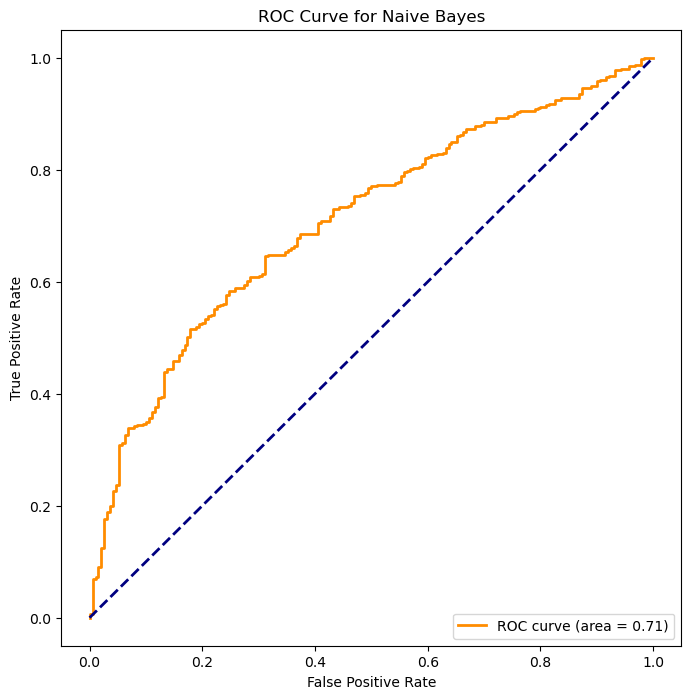

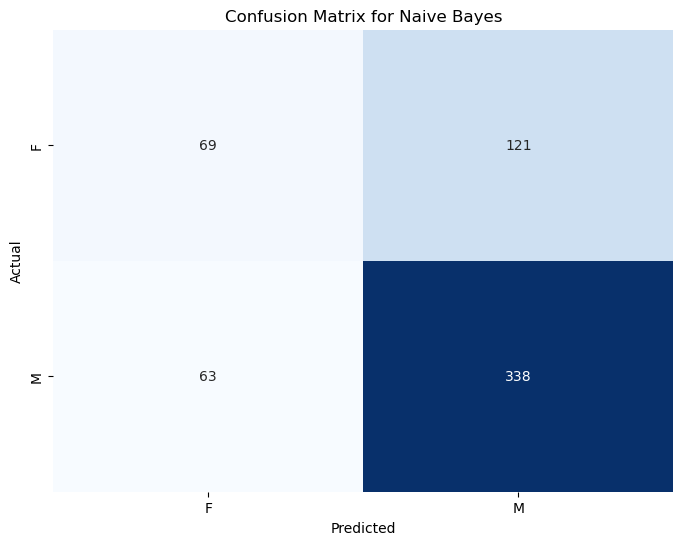

In [25]:
model_name = 'Naive Bayes'
# Define the pipeline with the preprocessor and the Naive Bayes model
pipeline_nb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__alpha': [0.01, 0.1, 1.0],
}

# Set up RandomizedSearchCV
model_nb = RandomizedSearchCV(
    pipeline_nb,
    param_distributions=param_dist,
    n_iter=10,  
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_nb.fit(X_train, y_train)

best_params = model_nb.best_params_

# Create a new pipeline with the best parameters
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB(alpha=best_params['classifier__alpha']))
])

# Fit the model on the entire training dataset
best_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = best_pipeline.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary = y_test.map(label_mapping)
y_pred_binary = pd.Series(y_pred).map(label_mapping)

# Print accuracy on the test set
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"{model_name} Accuracy: {accuracy:.3f}")

# Calculate AUC
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1] 
auc = roc_auc_score(y_test_binary, y_pred_proba)
print(f"{model_name} AUC: {auc:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


Classification Report for  Logistic Regression
              precision    recall  f1-score   support

           F       0.68      0.55      0.61       190
           M       0.80      0.88      0.84       401

    accuracy                           0.77       591
   macro avg       0.74      0.71      0.72       591
weighted avg       0.76      0.77      0.76       591

Logistic Regression Accuracy: 0.772
Logistic Regression AUC: 0.828


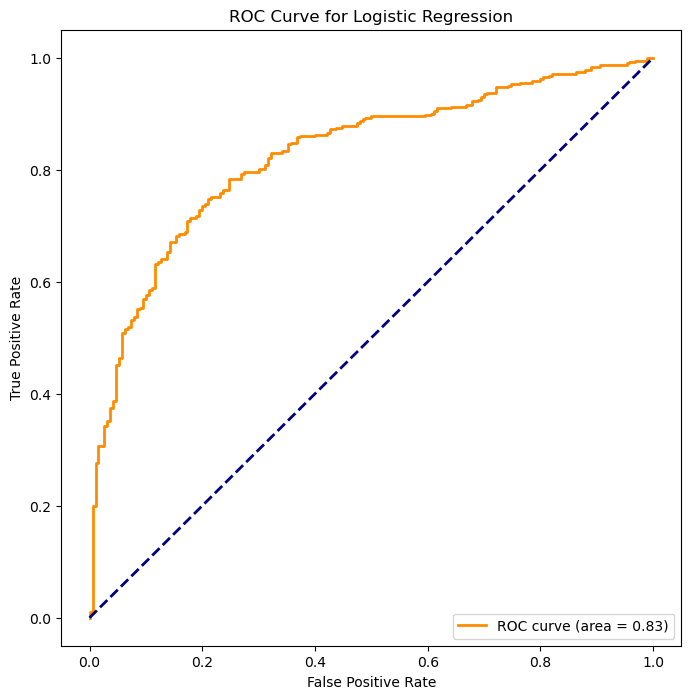

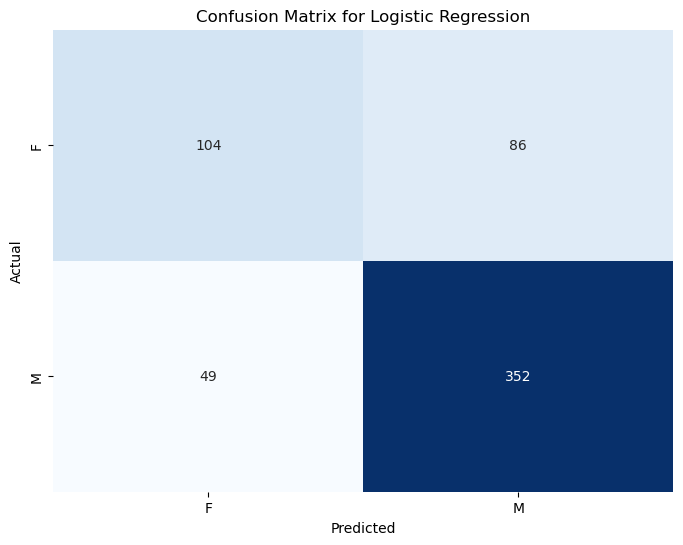

In [26]:
model_name = 'Logistic Regression'

# Define the pipeline with the preprocessor and the Logistic Regression model
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Set up RandomizedSearchCV
model_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42
)

model_lr.fit(X_train, y_train)

best_params = model_lr.best_params_

# Create a new pipeline with the best parameters
best_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty=best_params['classifier__penalty'], C=best_params['classifier__C']))
])

# Fit the model on the entire training dataset
best_pipeline_lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = best_pipeline_lr.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_lr))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_lr = y_test.map(label_mapping)
y_pred_binary_lr = pd.Series(y_pred_lr).map(label_mapping)

# Print accuracy on the test set
accuracy_lr = accuracy_score(y_test_binary_lr, y_pred_binary_lr)
print(f"{model_name} Accuracy: {accuracy_lr:.3f}")

# Calculate AUC
y_pred_proba_lr = best_pipeline_lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test_binary_lr, y_pred_proba_lr)
print(f"{model_name} AUC: {auc_lr:.3f}")

# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test_binary_lr, y_pred_proba_lr)
plt.figure(figsize=(8, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_lr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_lr = confusion_matrix(y_test_binary_lr, y_pred_binary_lr)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

Classification Report for  Random Forest
              precision    recall  f1-score   support

           F       0.80      0.04      0.08       190
           M       0.69      1.00      0.81       401

    accuracy                           0.69       591
   macro avg       0.74      0.52      0.45       591
weighted avg       0.72      0.69      0.58       591

Random Forest Accuracy: 0.689
Random Forest AUC: 0.799


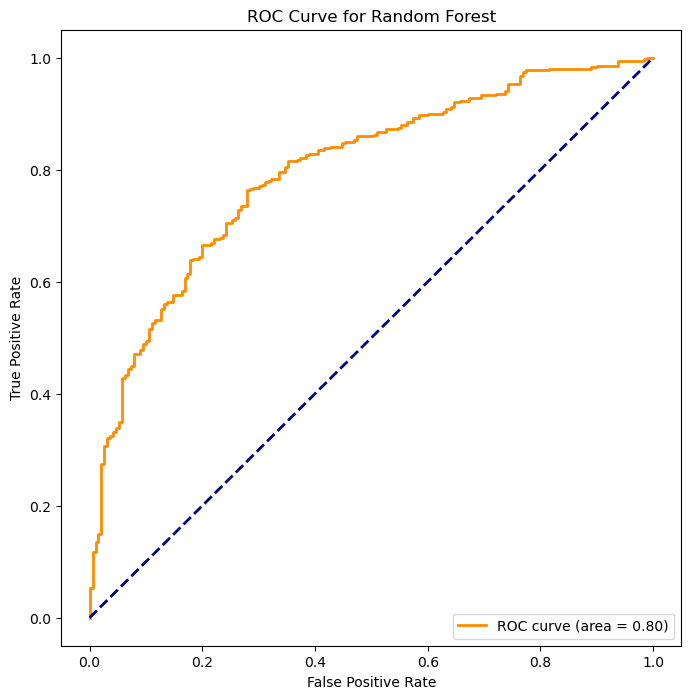

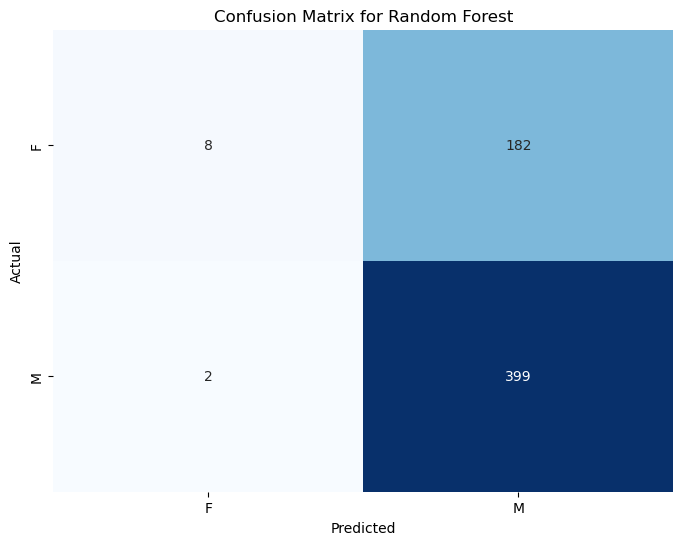

In [27]:
model_name = 'Random Forest'

# Define the pipeline with the preprocessor and the Random Forest model
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Set up RandomizedSearchCV
model_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_rf.fit(X_train, y_train)

best_params = model_rf.best_params_

# Create a new pipeline with the best parameters
best_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['classifier__n_estimators'],
        max_depth=best_params['classifier__max_depth'],
        min_samples_split=best_params['classifier__min_samples_split'],
        min_samples_leaf=best_params['classifier__min_samples_leaf']
    ))
])

# Fit the model on the entire training dataset
best_pipeline_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = best_pipeline_rf.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_rf))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_rf = y_test.map(label_mapping)
y_pred_binary_rf = pd.Series(y_pred_rf).map(label_mapping)

# Print accuracy on the test set
accuracy_rf = accuracy_score(y_test_binary_rf, y_pred_binary_rf)
print(f"{model_name} Accuracy: {accuracy_rf:.3f}")

# Calculate AUC
y_pred_proba_rf = best_pipeline_rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test_binary_rf, y_pred_proba_rf)
print(f"{model_name} AUC: {auc_rf:.3f}")

# Plot ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test_binary_rf, y_pred_proba_rf)
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_rf = confusion_matrix(y_test_binary_rf, y_pred_binary_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


Classification Report for  Support Vector Machine
              precision    recall  f1-score   support

           F       0.00      0.00      0.00       190
           M       0.68      1.00      0.81       401

    accuracy                           0.68       591
   macro avg       0.34      0.50      0.40       591
weighted avg       0.46      0.68      0.55       591

Support Vector Machine Accuracy: 0.679
Support Vector Machine AUC: 0.568


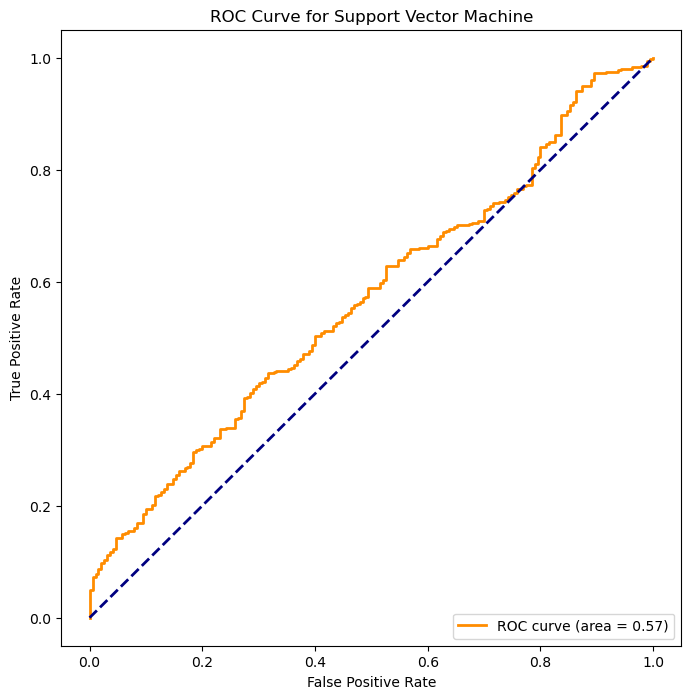

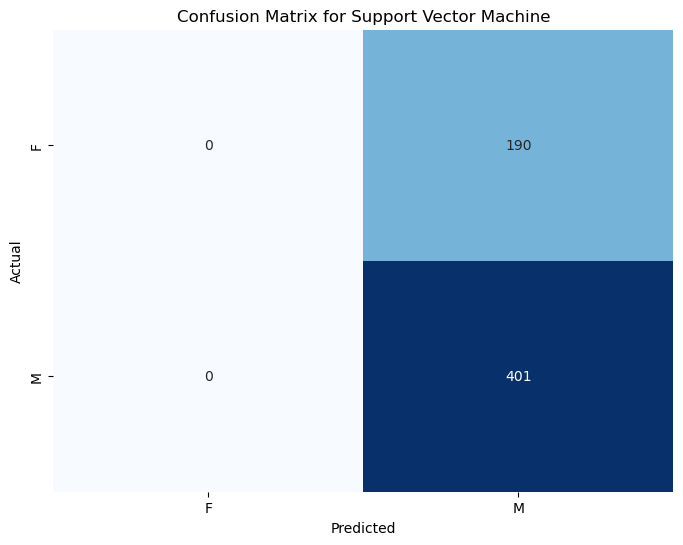

In [28]:
model_name = 'Support Vector Machine'

# Define the pipeline with the preprocessor and the SVM model
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42, probability=True))
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__degree': [2, 3, 4],
    'classifier__gamma': ['scale', 'auto']
}

# Set up RandomizedSearchCV
model_svm = RandomizedSearchCV(
    pipeline_svm,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_svm.fit(X_train, y_train)

best_params = model_svm.best_params_

# Create a new pipeline with the best parameters
best_pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        C=best_params['classifier__C'],
        kernel=best_params['classifier__kernel'],
        degree=best_params['classifier__degree'],
        gamma=best_params['classifier__gamma'],
        probability=True
    ))
])

# Fit the model on the entire training dataset
best_pipeline_svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = best_pipeline_svm.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_svm))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_svm = y_test.map(label_mapping)
y_pred_binary_svm = pd.Series(y_pred_svm).map(label_mapping)

# Print accuracy on the test set
accuracy_svm = accuracy_score(y_test_binary_svm, y_pred_binary_svm)
print(f"{model_name} Accuracy: {accuracy_svm:.3f}")

# Calculate AUC
y_pred_proba_svm = best_pipeline_svm.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test_binary_svm, y_pred_proba_svm)
print(f"{model_name} AUC: {auc_svm:.3f}")

# Plot ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test_binary_svm, y_pred_proba_svm)
plt.figure(figsize=(8, 8))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_svm = confusion_matrix(y_test_binary_svm, y_pred_binary_svm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


Now to address the class imbalance we will use `RandomUnderSampler` and examine the models' performance

RandomUnderSampler is a resampling technique commonly used in imbalanced classification problems to address the issue of unequal class distribution. Imbalanced datasets, where one class significantly outnumbers the other, can lead machine learning models to be biased towards the majority class. RandomUnderSampler works by randomly removing instances from the majority class until a more balanced distribution is achieved. This helps prevent the model from being overly influenced by the majority class, thus improving its ability to accurately predict the minority class. By reducing the dominance of the majority class, RandomUnderSampler can enhance the model's performance, especially in scenarios where the minority class is of particular interest and its correct identification is crucial. It is a straightforward yet effective technique, commonly used in conjunction with various classification algorithms to mitigate the challenges posed by imbalanced datasets.

The sampling_strategy parameter is used to specify the desired ratio of the number of samples in the minority class to the majority class after resampling. Here we wanted to resample the majority class to have the same number of samples as the minority class hence we selected the 'majority' sampling_strategy. 

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority', random_state = 42)
X_under, y_under = undersample.fit_resample(X, y)
y_under.value_counts()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, test_size=0.2, random_state = 42, stratify=y_under)

y_test.value_counts()

**Building Naive Bayes Model With RandomUnderSampler**

In [ ]:
model_name = 'Naive Bayes'
# Define the pipeline with the preprocessor and the Naive Bayes model
pipeline_nb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__alpha': [0.01, 0.1, 1.0],
}

# Set up RandomizedSearchCV
model_nb = RandomizedSearchCV(
    pipeline_nb,
    param_distributions=param_dist,
    n_iter=10,  
    cv=5,
    n_jobs = -1,
    #scoring='accuracy', 
    random_state=42
)

model_nb.fit(X_train, y_train)

best_params = model_nb.best_params_

# Create a new pipeline with the best parameters
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB(alpha=best_params['classifier__alpha']))
])

# Fit the model on the entire training dataset
best_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = best_pipeline.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary = y_test.map(label_mapping)
y_pred_binary = pd.Series(y_pred).map(label_mapping)

# Print accuracy/Precision on the test set
accuracy = accuracy_score(y_test_binary, y_pred_binary)
precision = precision_score(y_test_binary, y_pred_binary)

print(f"{model_name} Accuracy: {accuracy:.3f}")
print(f"{model_name} Precision: {precision:.3f}")

# Calculate AUC
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1] 
auc = roc_auc_score(y_test_binary, y_pred_proba)
print(f"{model_name} AUC: {auc:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


In [ ]:
model_name = 'Logistic Regression'

# Define the pipeline with the preprocessor and the Logistic Regression model
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Set up RandomizedSearchCV
model_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42
)

model_lr.fit(X_train, y_train)

best_params = model_lr.best_params_

# Create a new pipeline with the best parameters
best_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty=best_params['classifier__penalty'], C=best_params['classifier__C']))
])

# Fit the model on the entire training dataset
best_pipeline_lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = best_pipeline_lr.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_lr))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_lr = y_test.map(label_mapping)
y_pred_binary_lr = pd.Series(y_pred_lr).map(label_mapping)

# Print accuracy on the test set
accuracy = accuracy_score(y_test_binary_lr, y_pred_binary_lr)
precision = precision_score(y_test_binary_lr, y_pred_binary_lr)
print(f"{model_name} Accuracy: {accuracy:.3f}")
print(f"{model_name} Precision: {precision:.3f}")

# Calculate AUC
y_pred_proba_lr = best_pipeline_lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test_binary_lr, y_pred_proba_lr)
print(f"{model_name} AUC: {auc_lr:.3f}")

# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test_binary_lr, y_pred_proba_lr)
plt.figure(figsize=(8, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_lr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_lr = confusion_matrix(y_test_binary_lr, y_pred_binary_lr)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

In [ ]:
model_name = 'Random Forest'

# Define the pipeline with the preprocessor and the Random Forest model
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Set up RandomizedSearchCV
model_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_rf.fit(X_train, y_train)

best_params = model_rf.best_params_

# Create a new pipeline with the best parameters
best_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['classifier__n_estimators'],
        max_depth=best_params['classifier__max_depth'],
        min_samples_split=best_params['classifier__min_samples_split'],
        min_samples_leaf=best_params['classifier__min_samples_leaf']
    ))
])

# Fit the model on the entire training dataset
best_pipeline_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = best_pipeline_rf.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_rf))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_rf = y_test.map(label_mapping)
y_pred_binary_rf = pd.Series(y_pred_rf).map(label_mapping)

# Print accuracy/precision on the test set
accuracy = accuracy_score(y_test_binary_rf, y_pred_binary_rf)
precision = precision_score(y_test_binary_rf, y_pred_binary_rf)
print(f"{model_name} Accuracy: {accuracy:.3f}")
print(f"{model_name} Precision: {precision:.3f}")

# Calculate AUC
y_pred_proba_rf = best_pipeline_rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test_binary_rf, y_pred_proba_rf)
print(f"{model_name} AUC: {auc_rf:.3f}")

# Plot ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test_binary_rf, y_pred_proba_rf)
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_rf = confusion_matrix(y_test_binary_rf, y_pred_binary_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


In [ ]:
model_name = 'Support Vector Machine'

# Define the pipeline with the preprocessor and the SVM model
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42, probability=True))
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__degree': [2, 3, 4],
    'classifier__gamma': ['scale', 'auto']
}

# Set up RandomizedSearchCV
model_svm = RandomizedSearchCV(
    pipeline_svm,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_svm.fit(X_train, y_train)

best_params = model_svm.best_params_

# Create a new pipeline with the best parameters
best_pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        C=best_params['classifier__C'],
        kernel=best_params['classifier__kernel'],
        degree=best_params['classifier__degree'],
        gamma=best_params['classifier__gamma'],
        probability=True
    ))
])

# Fit the model on the entire training dataset
best_pipeline_svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = best_pipeline_svm.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_svm))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_svm = y_test.map(label_mapping)
y_pred_binary_svm = pd.Series(y_pred_svm).map(label_mapping)

# Print accuracy/precision on the test set
accuracy = accuracy_score(y_test_binary_svm, y_pred_binary_svm)
precision = precision_score(y_test_binary_svm, y_pred_binary_svm)
print(f"{model_name} Accuracy: {accuracy:.3f}")
print(f"{model_name} Precision: {precision:.3f}")

# Calculate AUC
y_pred_proba_svm = best_pipeline_svm.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test_binary_svm, y_pred_proba_svm)
print(f"{model_name} AUC: {auc_svm:.3f}")

# Plot ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test_binary_svm, y_pred_proba_svm)
plt.figure(figsize=(8, 8))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_svm = confusion_matrix(y_test_binary_svm, y_pred_binary_svm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


Next, we try `RandomOverSampler` and examine the models' performance

RandomOverSampler is a resampling technique employed in the context of imbalanced classification problems to tackle the challenge of unequal class distribution within a dataset. In scenarios where one class is significantly underrepresented, machine learning models may struggle to learn patterns associated with the minority class. RandomOverSampler addresses this issue by randomly duplicating instances of the minority class until a more balanced distribution is achieved. By synthetically increasing the representation of the minority class, this technique helps prevent the model from being biased towards the majority class, improving its ability to discern patterns in the minority class. RandomOverSampler is a simple yet effective approach that can be employed alongside various classification algorithms to enhance model performance, especially when the accurate prediction of the minority class is of particular importance.

In [29]:
oversample = RandomOverSampler(random_state = 42)
X_over, y_over = oversample.fit_resample(X, y)
y_over.value_counts()

character_gender
F    2003
M    2003
Name: count, dtype: int64

It appears that after performing oversampling, the dataset has been balanced with 2003 instances for both female (F) and male (M) characters. The oversampling has successfully achieved a balanced distribution of character genders in the dataset. Having an equal number of instances for both male and female characters will be beneficial as it helps prevent biases towards any particular gender.

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.2, random_state = 42, stratify=y_over)

y_test.value_counts()

character_gender
F    401
M    401
Name: count, dtype: int64

We split the data into 80:20 split for Train and test respectively.

Classification Report for  Naive Bayes
              precision    recall  f1-score   support

           F       0.80      0.89      0.84       401
           M       0.88      0.77      0.82       401

    accuracy                           0.83       802
   macro avg       0.84      0.83      0.83       802
weighted avg       0.84      0.83      0.83       802

Naive Bayes Accuracy: 0.832
Naive Bayes AUC: 0.924


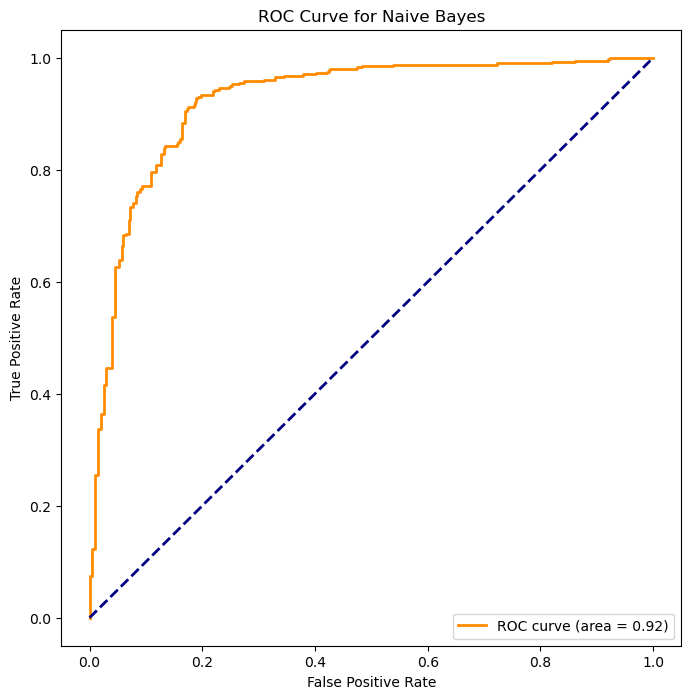

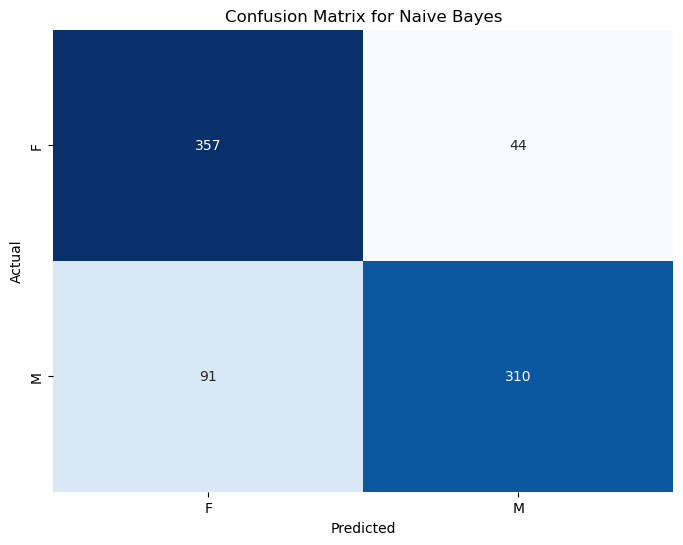

In [31]:
model_name = 'Naive Bayes'
# Define the pipeline with the preprocessor and the Naive Bayes model
pipeline_nb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__alpha': [0.01, 0.1, 1.0],
}

# Set up RandomizedSearchCV
model_nb = RandomizedSearchCV(
    pipeline_nb,
    param_distributions=param_dist,
    n_iter=10,  
    cv=5,
    n_jobs = -1,
    #scoring='accuracy', 
    random_state=42
)

model_nb.fit(X_train, y_train)

best_params = model_nb.best_params_

# Create a new pipeline with the best parameters
best_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', MultinomialNB(alpha=best_params['classifier__alpha']))
])

# Fit the model on the entire training dataset
best_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = best_pipeline.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary = y_test.map(label_mapping)
y_pred_binary = pd.Series(y_pred).map(label_mapping)

# Print accuracy on the test set
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"{model_name} Accuracy: {accuracy:.3f}")

# Calculate AUC
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1] 
auc = roc_auc_score(y_test_binary, y_pred_proba)
print(f"{model_name} AUC: {auc:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


The Naive Bayes model witnessed a significant performance boost when transitioning from an imbalanced to an oversampled, balanced dataset. Precision, recall, and F1-scores for both genders experienced notable improvements on the balanced data. For 'F' (Female), precision increased to 0.80, recall to 0.89, and F1-score to 0.84. Similarly, for 'M' (Male), precision improved to 0.88, recall to 0.77, and F1-score to 0.82.

These enhancements underscore the efficacy of oversampling in mitigating class imbalance, resulting in a more accurate and balanced Naive Bayes model for gender classification. The overall accuracy increased from 68.9% to 83.2%, and the AUC score surged to 92.4%.

Classification Report for  Logistic Regression
              precision    recall  f1-score   support

           F       0.78      0.75      0.76       401
           M       0.76      0.78      0.77       401

    accuracy                           0.77       802
   macro avg       0.77      0.77      0.77       802
weighted avg       0.77      0.77      0.77       802

Logistic Regression Accuracy: 0.768
Logistic Regression AUC: 0.842


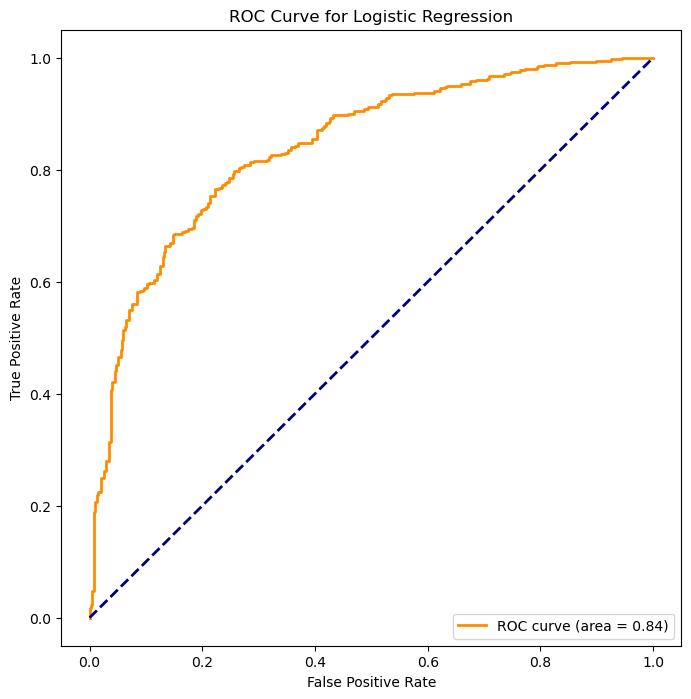

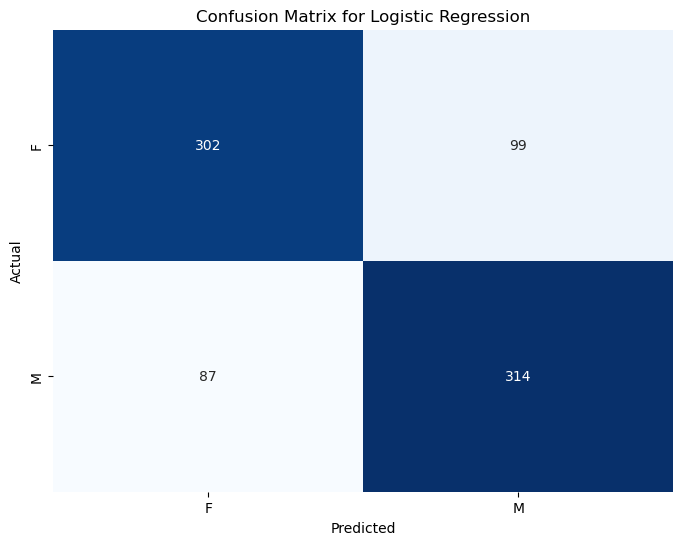

In [32]:
model_name = 'Logistic Regression'

# Define the pipeline with the preprocessor and the Logistic Regression model
pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Set up RandomizedSearchCV
model_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42
)

model_lr.fit(X_train, y_train)

best_params = model_lr.best_params_

# Create a new pipeline with the best parameters
best_pipeline_lr = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty=best_params['classifier__penalty'], C=best_params['classifier__C']))
])

# Fit the model on the entire training dataset
best_pipeline_lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = best_pipeline_lr.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_lr))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_lr = y_test.map(label_mapping)
y_pred_binary_lr = pd.Series(y_pred_lr).map(label_mapping)

# Print accuracy on the test set
accuracy_lr = accuracy_score(y_test_binary_lr, y_pred_binary_lr)
print(f"{model_name} Accuracy: {accuracy_lr:.3f}")

# Calculate AUC
y_pred_proba_lr = best_pipeline_lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test_binary_lr, y_pred_proba_lr)
print(f"{model_name} AUC: {auc_lr:.3f}")

# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test_binary_lr, y_pred_proba_lr)
plt.figure(figsize=(8, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_lr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_lr = confusion_matrix(y_test_binary_lr, y_pred_binary_lr)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

Logistic Regression demonstrated competitive performance on both unbalanced and oversampled balanced datasets. On the unbalanced data, it exhibited higher precision for 'M' (0.80) but faced challenges with 'F' recall (0.55), resulting in an imbalanced performance.

After oversampling, the model achieved more balanced metrics: precision of 0.78 for 'F' and 0.76 for 'M', along with 'F' recall at 0.75 and 'M' recall at 0.78.

F1-scores for both classes were 0.76 for 'F' and 0.77 for 'M'. Although the overall accuracy remained similar at 0.768, the oversampled model demonstrated improved balance in performance metrics, particularly in 'F' recall.

Classification Report for  Random Forest
              precision    recall  f1-score   support

           F       0.93      0.94      0.94       401
           M       0.94      0.93      0.94       401

    accuracy                           0.94       802
   macro avg       0.94      0.94      0.94       802
weighted avg       0.94      0.94      0.94       802

Random Forest Accuracy: 0.936
Random Forest AUC: 0.979


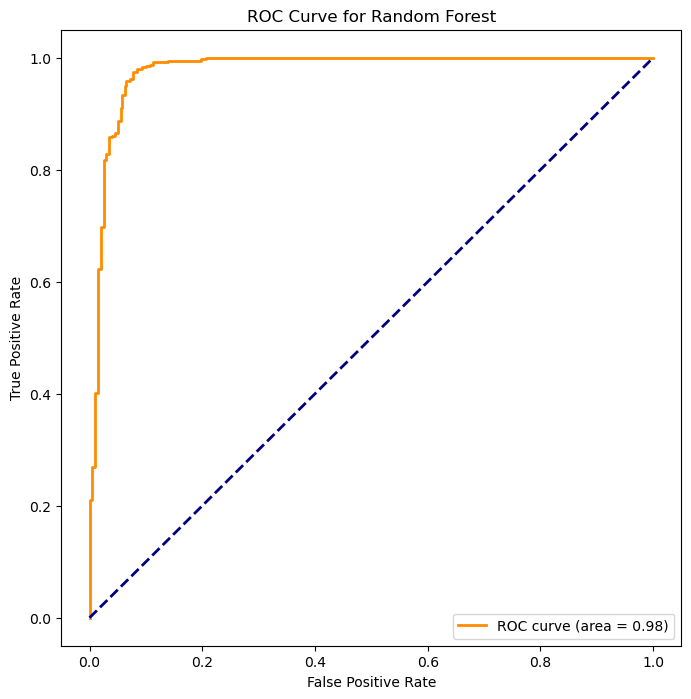

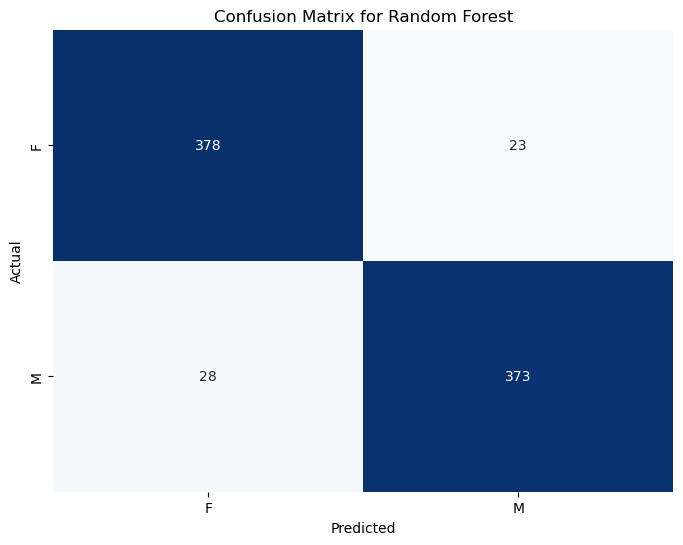

In [33]:
model_name = 'Random Forest'

# Define the pipeline with the preprocessor and the Random Forest model
pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Set up RandomizedSearchCV
model_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_rf.fit(X_train, y_train)

best_params = model_rf.best_params_

# Create a new pipeline with the best parameters
best_pipeline_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['classifier__n_estimators'],
        max_depth=best_params['classifier__max_depth'],
        min_samples_split=best_params['classifier__min_samples_split'],
        min_samples_leaf=best_params['classifier__min_samples_leaf']
    ))
])

# Fit the model on the entire training dataset
best_pipeline_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = best_pipeline_rf.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_rf))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_rf = y_test.map(label_mapping)
y_pred_binary_rf = pd.Series(y_pred_rf).map(label_mapping)

# Print accuracy on the test set
accuracy_rf = accuracy_score(y_test_binary_rf, y_pred_binary_rf)
print(f"{model_name} Accuracy: {accuracy_rf:.3f}")

# Calculate AUC
y_pred_proba_rf = best_pipeline_rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test_binary_rf, y_pred_proba_rf)
print(f"{model_name} AUC: {auc_rf:.3f}")

# Plot ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test_binary_rf, y_pred_proba_rf)
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_rf = confusion_matrix(y_test_binary_rf, y_pred_binary_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


The Random Forest model encountered challenges in predicting instances of the minority class ('F') on unbalanced data, resulting in imbalanced precision (0.80) and recall (0.04). The overall accuracy stands at 0.689, reflecting the impact of skewed data distribution.

Upon oversampling to achieve a balanced dataset, a significant improvement is observed. Precision, recall, and F1-scores for both classes ('F' and 'M') become highly balanced, with precision and recall for 'F' reaching 0.93 and 0.94, respectively, and an impressive F1-score of 0.94. For 'M', precision, recall, and F1-scores all remain high at 0.94. 

This leads to an overall accuracy of 0.936, showcasing the effectiveness of addressing class imbalance. The AUC score also experiences a notable increase, reaching 0.979, underscoring the significance of this improvement in discriminatory ability. This demonstrates that the oversampled model outperforms the model trained on unbalanced data across various performance metrics.

Classification Report for  Support Vector Machine
              precision    recall  f1-score   support

           F       0.68      0.75      0.72       401
           M       0.72      0.65      0.69       401

    accuracy                           0.70       802
   macro avg       0.70      0.70      0.70       802
weighted avg       0.70      0.70      0.70       802

Support Vector Machine Accuracy: 0.702
Support Vector Machine AUC: 0.775


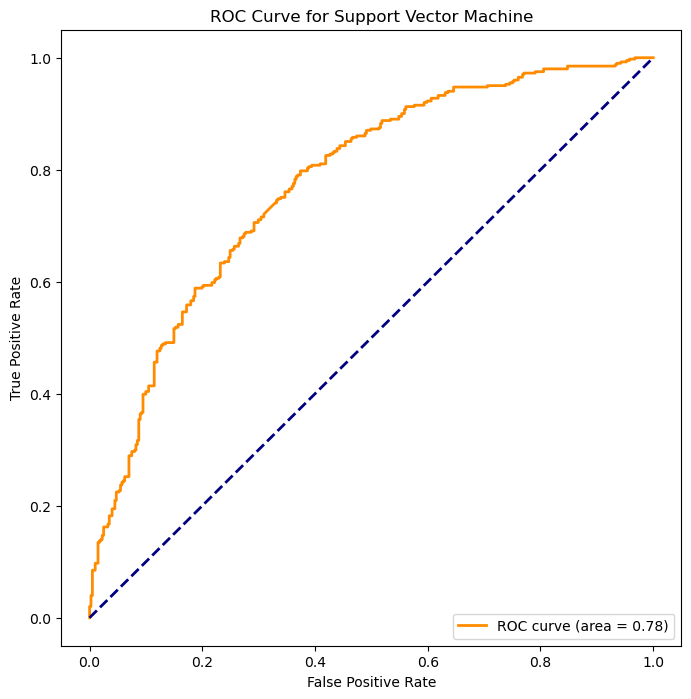

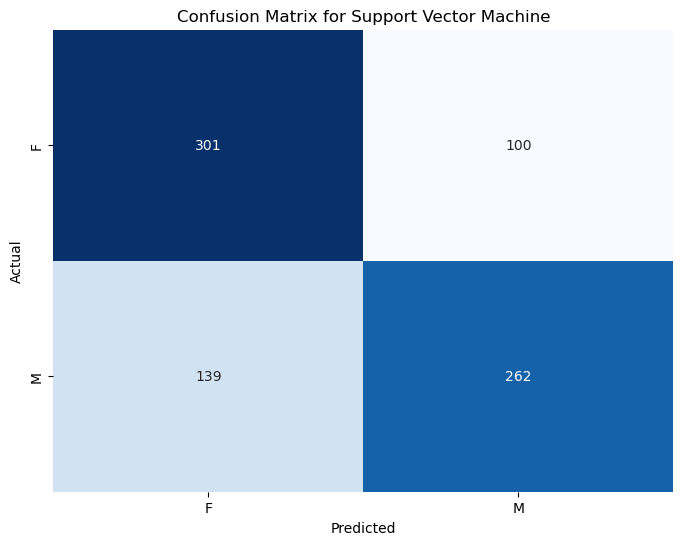

In [34]:
model_name = 'Support Vector Machine'

# Define the pipeline with the preprocessor and the SVM model
pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(random_state=42, probability=True))
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__degree': [2, 3, 4],
    'classifier__gamma': ['scale', 'auto']
}

# Set up RandomizedSearchCV
model_svm = RandomizedSearchCV(
    pipeline_svm,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_svm.fit(X_train, y_train)

best_params = model_svm.best_params_

# Create a new pipeline with the best parameters
best_pipeline_svm = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(
        C=best_params['classifier__C'],
        kernel=best_params['classifier__kernel'],
        degree=best_params['classifier__degree'],
        gamma=best_params['classifier__gamma'],
        probability=True
    ))
])

# Fit the model on the entire training dataset
best_pipeline_svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = best_pipeline_svm.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_svm))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_svm = y_test.map(label_mapping)
y_pred_binary_svm = pd.Series(y_pred_svm).map(label_mapping)

# Print accuracy on the test set
accuracy_svm = accuracy_score(y_test_binary_svm, y_pred_binary_svm)
print(f"{model_name} Accuracy: {accuracy_svm:.3f}")

# Calculate AUC
y_pred_proba_svm = best_pipeline_svm.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test_binary_svm, y_pred_proba_svm)
print(f"{model_name} AUC: {auc_svm:.3f}")

# Plot ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test_binary_svm, y_pred_proba_svm)
plt.figure(figsize=(8, 8))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_svm = confusion_matrix(y_test_binary_svm, y_pred_binary_svm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


The Support Vector Machine (SVM) encountered significant challenges when applied to unbalanced data, particularly in predicting instances of the minority class ('F'). For 'F', precision, recall, and F1-score were remarkably low, all at 0.00, resulting in an overall accuracy of 0.679 and a limited discriminatory ability with an AUC score of 0.568.

Upon oversampling to achieve balance, notable improvements were observed across metrics for both classes ('F' and 'M'). Precision for 'F' increased to 0.68, with a corresponding recall of 0.75 and an improved F1-score of 0.72. For 'M', precision was 0.72, with recall at 0.65 and an F1-score of 0.69. The overall accuracy increased to 0.702, and the AUC score improved to 0.775, indicative of enhanced model performance. 

In [35]:
from imblearn.over_sampling import SMOTE
smote_oversampler = SMOTE(random_state = 42)

In [36]:
X_preproc = preprocessor.fit_transform(X)
X_smote, y_smote = smote_oversampler.fit_resample(X_preproc, y)
y_over.value_counts()

character_gender
F    2003
M    2003
Name: count, dtype: int64

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.2, random_state = 42, stratify=y_over)

y_test.value_counts()

character_gender
F    401
M    401
Name: count, dtype: int64

Classification Report for  Naive Bayes
              precision    recall  f1-score   support

           F       0.81      0.91      0.85       401
           M       0.89      0.78      0.84       401

    accuracy                           0.85       802
   macro avg       0.85      0.85      0.84       802
weighted avg       0.85      0.85      0.84       802

Naive Bayes Accuracy: 0.845
Naive Bayes AUC: 0.928


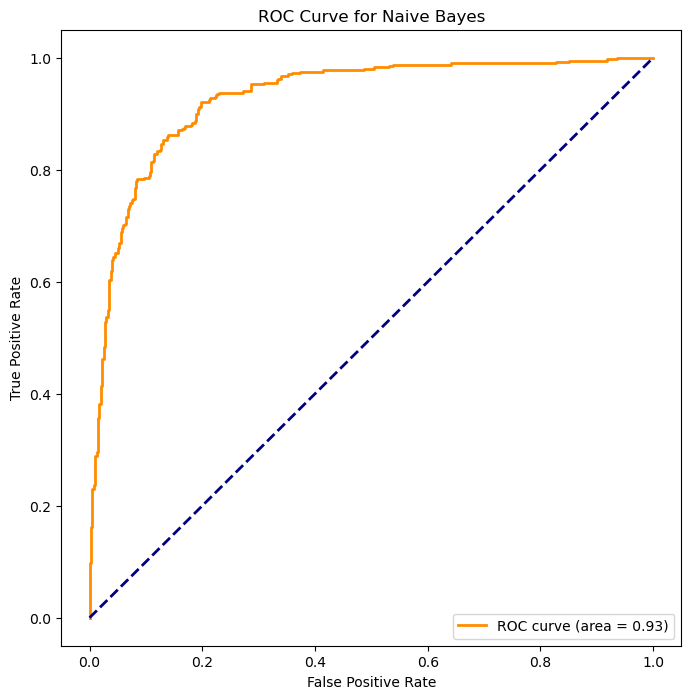

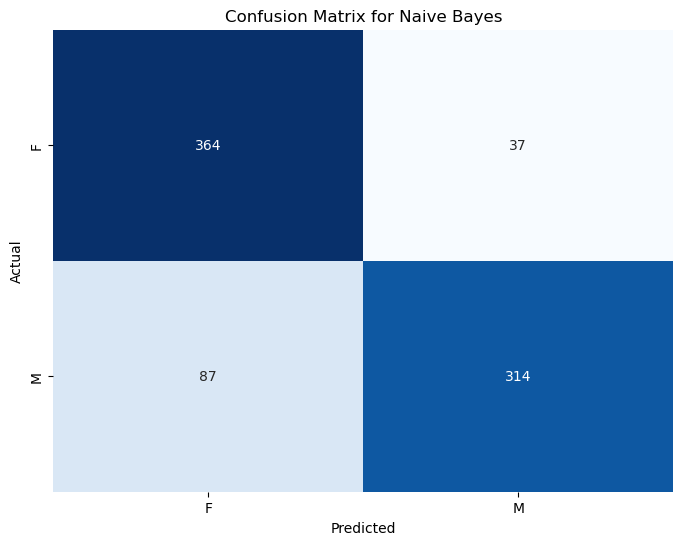

In [38]:
model_name = 'Naive Bayes'
# Define the pipeline with the preprocessor and the Naive Bayes model
pipeline_nb = Pipeline(steps=[
    ('classifier', MultinomialNB())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__alpha': [0.01, 0.1, 1.0],
}

# Set up RandomizedSearchCV
model_nb = RandomizedSearchCV(
    pipeline_nb,
    param_distributions=param_dist,
    n_iter=10,  
    cv=5,
    n_jobs = -1,
    #scoring='accuracy', 
    random_state=42
)

model_nb.fit(X_train, y_train)

best_params = model_nb.best_params_

# Create a new pipeline with the best parameters
best_pipeline = Pipeline(steps=[
    ('classifier', MultinomialNB(alpha=best_params['classifier__alpha']))
])

# Fit the model on the entire training dataset
best_pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = best_pipeline.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary = y_test.map(label_mapping)
y_pred_binary = pd.Series(y_pred).map(label_mapping)

# Print accuracy on the test set
accuracy = accuracy_score(y_test_binary, y_pred_binary)
print(f"{model_name} Accuracy: {accuracy:.3f}")

# Calculate AUC
y_pred_proba = best_pipeline.predict_proba(X_test)[:, 1] 
auc = roc_auc_score(y_test_binary, y_pred_proba)
print(f"{model_name} AUC: {auc:.3f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_pred_proba)
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


The Naive Bayes model's performance on oversampled balanced data using the SMOTE technique exhibits substantial improvements compared to its performance on unbalanced data. Precision for 'F' significantly increased from 0.52 to 0.81, accompanied by a notable rise in recall from 0.36 to 0.91, resulting in an impressive F1-score of 0.85. For 'M', precision remains high at 0.89, with a recall of 0.78, leading to an F1-score of 0.84. The overall accuracy surged from 0.689 to 0.845, underscoring the balanced and accurate prediction for both genders. 


The AUC score experienced a remarkable improvement from 0.709 to 0.928, signifying enhanced discriminatory ability on the oversampled balanced data. The application of the SMOTE technique demonstrates its effectiveness in addressing class imbalance, yielding a Naive Bayes model with superior performance metrics compared to the unbalanced counterpart.

Classification Report for  Logistic Regression
              precision    recall  f1-score   support

           F       0.76      0.79      0.78       401
           M       0.78      0.75      0.77       401

    accuracy                           0.77       802
   macro avg       0.77      0.77      0.77       802
weighted avg       0.77      0.77      0.77       802

Logistic Regression Accuracy: 0.772
Logistic Regression AUC: 0.848


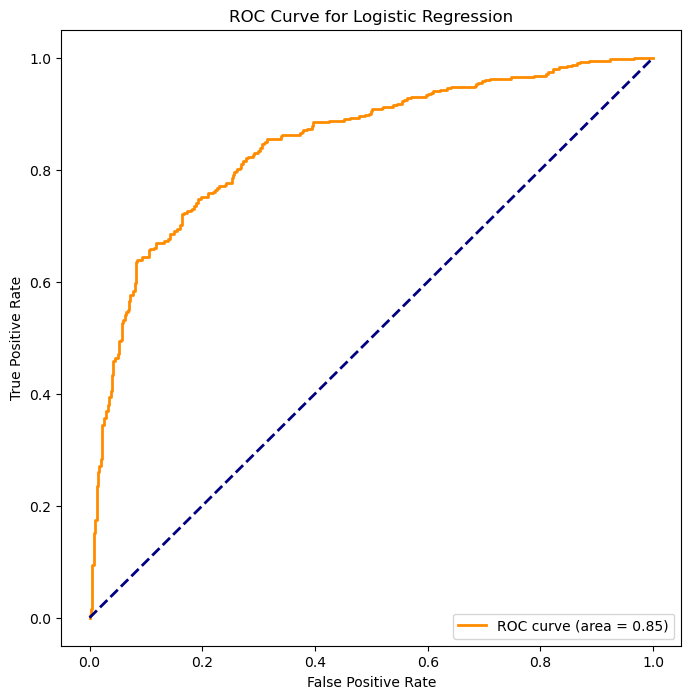

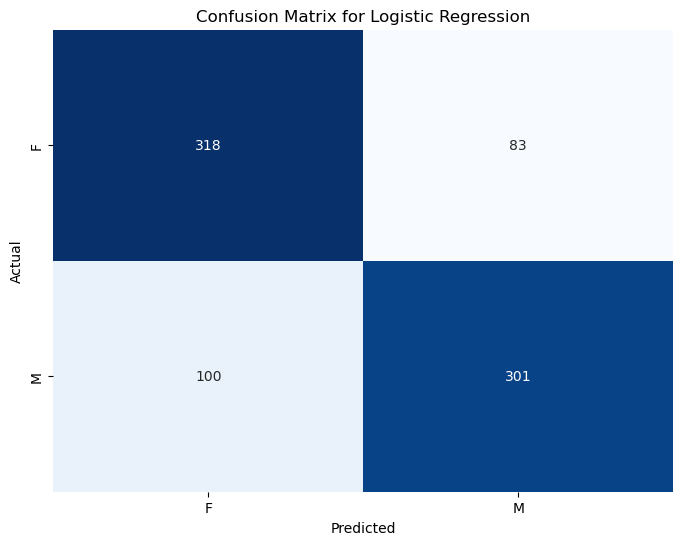

In [39]:
model_name = 'Logistic Regression'

# Define the pipeline with the preprocessor and the Logistic Regression model
pipeline_lr = Pipeline(steps=[
    ('classifier', LogisticRegression())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
}

# Set up RandomizedSearchCV
model_lr = RandomizedSearchCV(
    pipeline_lr,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    random_state=42
)

model_lr.fit(X_train, y_train)

best_params = model_lr.best_params_

# Create a new pipeline with the best parameters
best_pipeline_lr = Pipeline(steps=[
    ('classifier', LogisticRegression(penalty=best_params['classifier__penalty'], C=best_params['classifier__C']))
])

# Fit the model on the entire training dataset
best_pipeline_lr.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = best_pipeline_lr.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_lr))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_lr = y_test.map(label_mapping)
y_pred_binary_lr = pd.Series(y_pred_lr).map(label_mapping)

# Print accuracy on the test set
accuracy_lr = accuracy_score(y_test_binary_lr, y_pred_binary_lr)
print(f"{model_name} Accuracy: {accuracy_lr:.3f}")

# Calculate AUC
y_pred_proba_lr = best_pipeline_lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test_binary_lr, y_pred_proba_lr)
print(f"{model_name} AUC: {auc_lr:.3f}")

# Plot ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y_test_binary_lr, y_pred_proba_lr)
plt.figure(figsize=(8, 8))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_lr))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_lr = confusion_matrix(y_test_binary_lr, y_pred_binary_lr)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()

In contrast to its performance on unbalanced data, logistic regression on balanced data using SMOTE oversampling exhibits enhanced precision, recall, and F1-score metrics for both classes ('F' and 'M'). On balanced data, precision for 'F' and 'M' reaches 0.76 and 0.78, respectively, showcasing a balanced predictive ability. The recall for 'F' and 'M' is also well-balanced at 0.79 and 0.75, contributing to F1-scores of 0.78 for 'F' and 0.77 for 'M'. 

The overall accuracy remains consistent at 0.772. Notably, the AUC score demonstrates a significant improvement, rising to 0.848, indicating enhanced discriminatory ability on the balanced dataset compared to the unbalanced scenario. The application of SMOTE oversampling effectively addresses class imbalance, resulting in a more robust logistic regression model with improved performance metrics.

Classification Report for  Random Forest
              precision    recall  f1-score   support

           F       0.89      0.82      0.85       401
           M       0.83      0.90      0.86       401

    accuracy                           0.86       802
   macro avg       0.86      0.86      0.86       802
weighted avg       0.86      0.86      0.86       802

Random Forest Accuracy: 0.855
Random Forest AUC: 0.937


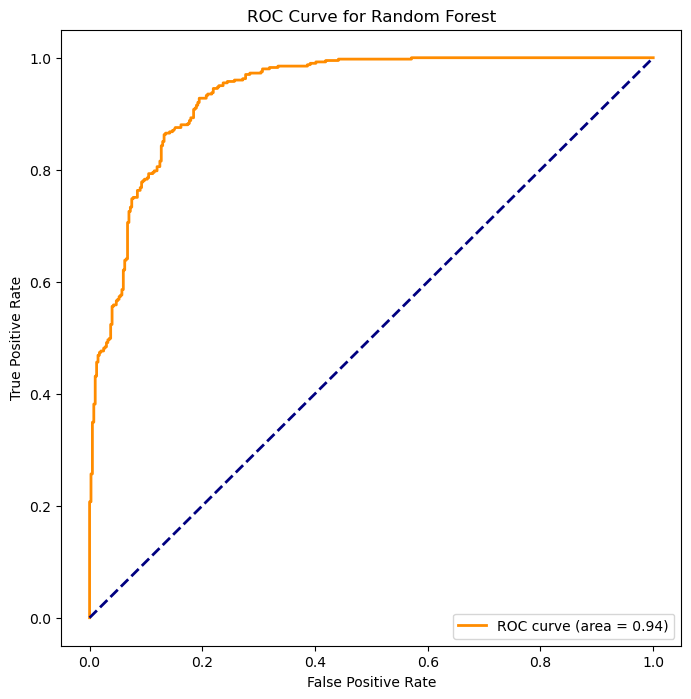

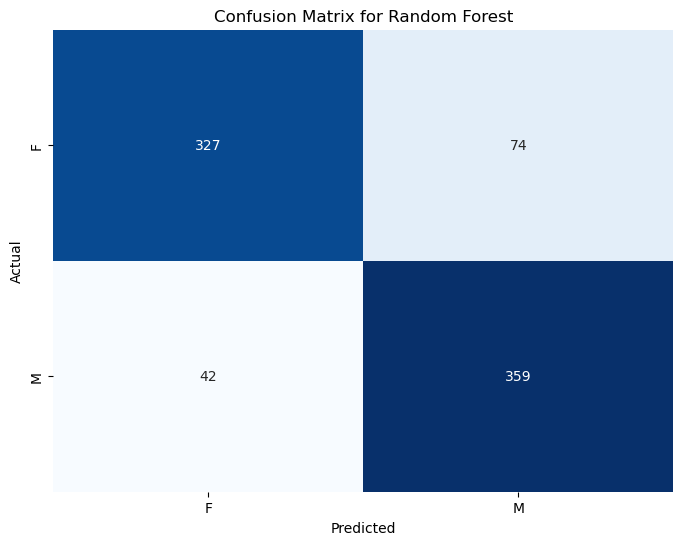

In [40]:
model_name = 'Random Forest'

# Define the pipeline with the preprocessor and the Random Forest model
pipeline_rf = Pipeline(steps=[
    ('classifier', RandomForestClassifier())
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__n_estimators': [50, 100, 150, 200],
    'classifier__max_depth': [None, 10, 20, 30, 40, 50],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Set up RandomizedSearchCV
model_rf = RandomizedSearchCV(
    pipeline_rf,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_rf.fit(X_train, y_train)

best_params = model_rf.best_params_

# Create a new pipeline with the best parameters
best_pipeline_rf = Pipeline(steps=[
    ('classifier', RandomForestClassifier(
        n_estimators=best_params['classifier__n_estimators'],
        max_depth=best_params['classifier__max_depth'],
        min_samples_split=best_params['classifier__min_samples_split'],
        min_samples_leaf=best_params['classifier__min_samples_leaf']
    ))
])

# Fit the model on the entire training dataset
best_pipeline_rf.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = best_pipeline_rf.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_rf))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_rf = y_test.map(label_mapping)
y_pred_binary_rf = pd.Series(y_pred_rf).map(label_mapping)

# Print accuracy on the test set
accuracy_rf = accuracy_score(y_test_binary_rf, y_pred_binary_rf)
print(f"{model_name} Accuracy: {accuracy_rf:.3f}")

# Calculate AUC
y_pred_proba_rf = best_pipeline_rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test_binary_rf, y_pred_proba_rf)
print(f"{model_name} AUC: {auc_rf:.3f}")

# Plot ROC curve
fpr_rf, tpr_rf, _ = roc_curve(y_test_binary_rf, y_pred_proba_rf)
plt.figure(figsize=(8, 8))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_rf))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_rf = confusion_matrix(y_test_binary_rf, y_pred_binary_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


In comparison to its performance on unbalanced data, Random Forest on balanced data with SMOTE oversampling demonstrates substantial improvements in precision, recall, and F1-score metrics for both classes ('F' and 'M'). Precision for 'F' and 'M' reaches 0.89 and 0.83, respectively, indicating a well-balanced predictive ability. The recall for 'F' and 'M' is also balanced at 0.82 and 0.90, contributing to impressive F1-scores of 0.85 for 'F' and 0.86 for 'M'. 

The overall accuracy experiences a notable increase to 0.855. Particularly noteworthy is the surge in the AUC score to 0.937, indicating vastly improved discriminatory ability on the balanced dataset compared to the unbalanced counterpart. The application of SMOTE oversampling proves effective in addressing class imbalance, resulting in a Random Forest model with enhanced performance metrics and increased robustness.

Classification Report for  Support Vector Machine
              precision    recall  f1-score   support

           F       0.71      0.79      0.75       401
           M       0.76      0.68      0.72       401

    accuracy                           0.73       802
   macro avg       0.73      0.73      0.73       802
weighted avg       0.73      0.73      0.73       802

Support Vector Machine Accuracy: 0.732
Support Vector Machine AUC: 0.808


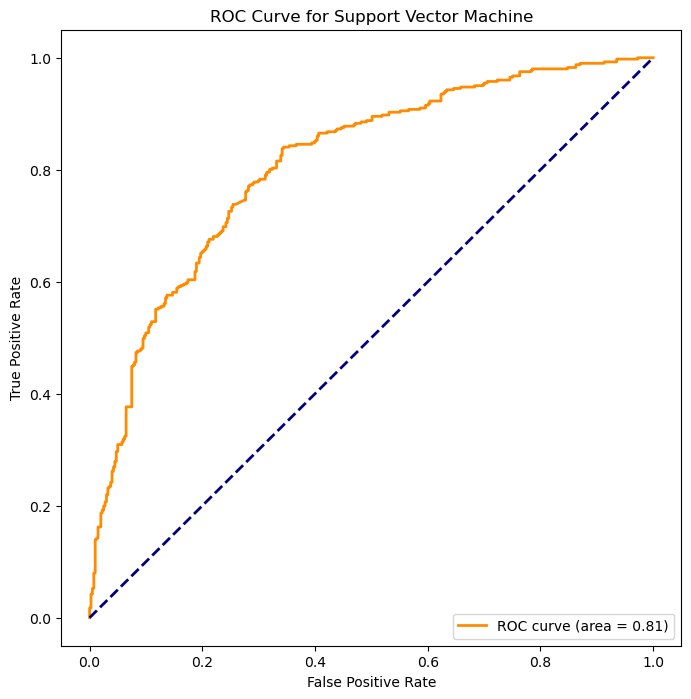

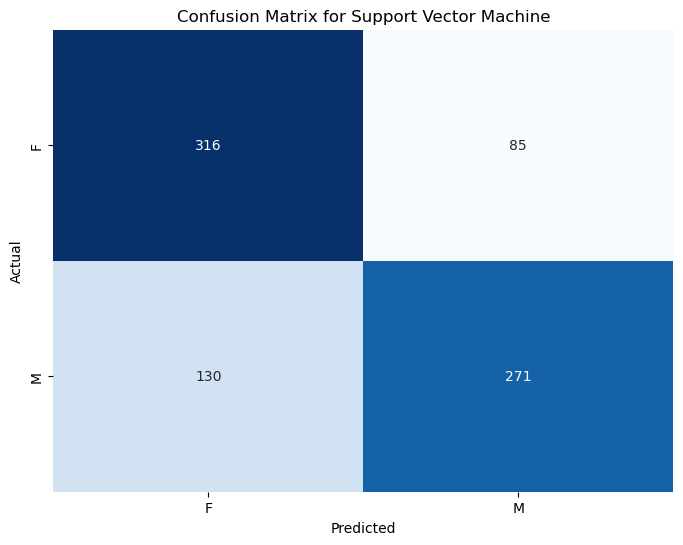

In [41]:
model_name = 'Support Vector Machine'

# Define the pipeline with the preprocessor and the SVM model
pipeline_svm = Pipeline(steps=[
    ('classifier', SVC(random_state=42, probability=True))
])

# Define the hyperparameter grid for RandomizedSearchCV
param_dist = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__degree': [2, 3, 4],
    'classifier__gamma': ['scale', 'auto']
}

# Set up RandomizedSearchCV
model_svm = RandomizedSearchCV(
    pipeline_svm,
    param_distributions=param_dist,
    n_iter=10,
    cv=5,
    n_jobs = -1,
    random_state=42
)

model_svm.fit(X_train, y_train)

best_params = model_svm.best_params_

# Create a new pipeline with the best parameters
best_pipeline_svm = Pipeline(steps=[
    ('classifier', SVC(
        C=best_params['classifier__C'],
        kernel=best_params['classifier__kernel'],
        degree=best_params['classifier__degree'],
        gamma=best_params['classifier__gamma'],
        probability=True
    ))
])

# Fit the model on the entire training dataset
best_pipeline_svm.fit(X_train, y_train)

# Predict on the test set
y_pred_svm = best_pipeline_svm.predict(X_test)

# Generate classification report
print("Classification Report for ", model_name)
print(classification_report(y_test, y_pred_svm))

# Map labels to binary format
label_mapping = {'F': 0, 'M': 1}
y_test_binary_svm = y_test.map(label_mapping)
y_pred_binary_svm = pd.Series(y_pred_svm).map(label_mapping)

# Print accuracy on the test set
accuracy_svm = accuracy_score(y_test_binary_svm, y_pred_binary_svm)
print(f"{model_name} Accuracy: {accuracy_svm:.3f}")

# Calculate AUC
y_pred_proba_svm = best_pipeline_svm.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test_binary_svm, y_pred_proba_svm)
print(f"{model_name} AUC: {auc_svm:.3f}")

# Plot ROC curve
fpr_svm, tpr_svm, _ = roc_curve(y_test_binary_svm, y_pred_proba_svm)
plt.figure(figsize=(8, 8))
plt.plot(fpr_svm, tpr_svm, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_svm))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {model_name}')
plt.legend(loc="lower right")
plt.show()

# Calculate the confusion matrix
conf_matrix_svm = confusion_matrix(y_test_binary_svm, y_pred_binary_svm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['F', 'M'], yticklabels=['F', 'M'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix for {model_name}')
plt.show()


In comparison to its performance on unbalanced data, Support Vector Machine (SVM) on balanced data with SMOTE oversampling shows improvements in precision, recall, and F1-score metrics for both classes ('F' and 'M'). Precision for 'F' and 'M' reaches 0.71 and 0.76, respectively, indicating a balanced predictive ability. The recall for 'F' and 'M' is also well-balanced at 0.79 and 0.68, contributing to respectable F1-scores of 0.75 for 'F' and 0.72 for 'M'.

The overall accuracy experiences an increase to 0.732. The AUC score demonstrates an improvement to 0.808, indicating enhanced discriminatory ability on the balanced dataset compared to the unbalanced scenario. The application of SMOTE oversampling effectively mitigates class imbalance, resulting in a more robust SVM model with improved performance metrics and increased accuracy.

In evaluating the effectiveness of oversampling techniques—random oversampling and SMOTE—across four models (Naive Bayes, Logistic Regression, Random Forest, and Support Vector Machine), SMOTE consistently emerged as the superior approach. On unbalanced data, random oversampling provided some relief but failed to achieve optimal balance, leaving imbalances in precision, recall, and F1-scores for the minority class ('F'). 

In contrast, SMOTE oversampling demonstrated remarkable success in creating a balanced dataset, leading to substantial improvements in precision, recall, and F1-scores for both classes. Notably, SMOTE consistently elevated discriminatory ability, as indicated by higher AUC scores across all models, reflecting improved capacity to distinguish between classes. 

The superior performance of SMOTE underscores its effectiveness in addressing class imbalance, promoting robust machine learning models with enhanced predictive accuracy and balanced outcomes.

## Creating data for further Analysis and extended goals

In [ ]:
column_names = ['speaker_id', 'listener_id', 'movie_id', 'line_id',]
conversations_df = pd.read_csv('dataset/movie_conversations.tsv', sep='\t', header=None, names=column_names, on_bad_lines='skip')
print("SUCESS : 'Conversations' dataframe created from 'movie_conversations.tsv'\n")
print('Here is a snapshot of data')
conversations_df.head()

Data loaded. Now lets do some cleaning of the data

In [ ]:
conversations_df['line_id'] = conversations_df['line_id'].str.split(' ')
conversations_df = conversations_df.loc[conversations_df.index.repeat(conversations_df['line_id'].apply(len))]
conversations_df = conversations_df.explode('line_id')
conversations_df = conversations_df.reset_index(drop=True)
conversations_df['line_id'] = conversations_df['line_id'].str.strip("[]")
conversations_df['line_id'] = conversations_df['line_id'].str.strip("''")
conversations_df

Now that we have the conversations of each character. Let's merge it with our final_df

In [ ]:
character_conversations_df = pd.merge(conversations_df, final_df, how='inner', on='line_id')
character_conversations_df

We can see that the dataset contains too many duplicates. Let's drop the duplicates

In [ ]:
character_conversations_df = character_conversations_df.drop_duplicates()

Let's rename columns created during the merge

In [ ]:
character_conversations_df = character_conversations_df.rename(columns={"movie_id_x": "movie_id"})
character_conversations_df

Dropping movie_id_y as it was created in merge and is not needed

In [ ]:
character_conversations_df = character_conversations_df.drop(columns=['movie_id_y'])

In [ ]:
character_conversations_df.columns

The Columns Speaker_id and character_id are the same. Hence dropping character_id.
Moreover, we do not need the character_dialog_count for further analysis hence dropping it.

Similarly, renaming the character_name, character_gender, character_line columns as 

speaker_name, speaker_gender, speaker_dialogue for better understanding in further analysis.


In [ ]:
character_conversations_df = character_conversations_df.drop(columns=['character_id', 'character_dialog_count'])

In [ ]:
character_conversations_df = character_conversations_df.rename(columns={"character_gender": "speaker_gender", "character_name": "speaker_name", "character_line": "speaker_dialogue"})
character_conversations_df

Let's dump the dataframe

In [ ]:
character_conversations_df.to_csv('character_conversations_df.csv', sep=',', index=False, encoding='utf-8')